## Shape-based Evaluation of Epidemic Forecasts



## Definitions

Shapelet : Shapelets are defined as “subsequences that are in some sense maximally representative of a class”. Informally, if we assume a binary classification setting, a shapelet is discriminant if it is present in most series of one class and absent from series of the other class.<br>

In this work, we have used 6 shapelets which depict various stages in a pandemic wave

__Flat__: [1, 1, 1, 1, 1] <br>
__Stable-inc__: [1 ,2, 3, 4, 5], i.e., linear<br>
__Stable-dec__: [5, 4, 3, 2, 1], i.e., linear but decreasing<br>
__Surge__: [exp(-1/2) ,exp(0/2), exp(1/2), exp(2/2), exp(3/2)], i.e., like exp(x)<br>
__Peaking__: - [exp(1/2) ,exp(0/2) ,exp(-1/2) ,exp(-2/2), exp(-3/2)], i.e., like -exp(-x)<br>
__At/near peak__:  - [exp(-1/2), exp(0/2), exp(1/2), exp(2/2), exp(3/2)], i.e., like -exp(x)


### Pearson Correlation:

<img src="https://editor.analyticsvidhya.com/uploads/39170Formula.JPG" width="400" height="500">

### Cosine Similarity
cosine similarity for comparing the two vectors, which is defined as follows:
\begin{equation}
\cos ({\bf t},{\bf e})= {{\bf t} {\bf e} \over \|{\bf t}\| \|{\bf e}\|} = \frac{ \sum_{i=1}^{n}{{\bf t}_i{\bf e}_i} }{ \sqrt{\sum_{i=1}^{n}{({\bf t}_i)^2}} \sqrt{\sum_{i=1}^{n}{({\bf e}_i)^2}} }
\end{equation}




## Broard Steps

For Cases and Deaths,

* Find the similarity of the ground truth with our shapelets. This will give us a vector
* Find the similarity of the model forecasts with our shapelets. This will give us another vector
* Take the cosine similarity between the two (negative inputs are okay!). The similarity between the classes will be inherently captured
* Take the mean of pairwise cosine similarity between the models. This will give us the agreement between models
*Add another "Shapelet Ensemble Model" whose vector output is the mean of the model vectors. This is analogous to the majority classifier.

## Development Code Begins

### Library Imports


In [670]:
import time
import pandas as pd

import numpy as np

from numpy import corrcoef as pcor

from numpy import exp as exp
from scipy import spatial

from itertools import combinations

import pickle

from datetime import datetime, timedelta

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np


### Define Paths and hyper Params


In [671]:
start = time.time()
Runtype = "Cases"#### choose Deaths for generating results for deaths and Cases for generating case results

if Runtype =='Cases':
    print("Process will run for Cases")

    Input_path = '../Data_Sources/Cases/'

    Ouput_path = '../Data_Sources/Cases/Output_Files/'

    Actual_incidence_path = Input_path+"/Input_Files/Actual_Incidence_Data/"

    pickle_path = Input_path+"Pickle_Objects/"

    Visualization_path = Input_path+"Visualizations/"
else:
    print("Process will run for Deaths")
    Input_path = '../Data_Sources/Deaths/'

    Ouput_path = '../Data_Sources/Deaths/Output_Files/'

    Actual_incidence_path = Input_path+"/Input_Files/Actual_Incidence_Data/"

    pickle_path = Input_path+"Pickle_Objects/"

    Visualization_path = Input_path+"Visualizations/"


export_visualizations = False ### when this is set to True, visualizations will be expored. If False, visualizations will only be displayed not exported
Data_refresh = 0 

# Smoothening_param= 3 ### make it dynamic in code below 


### if it is set to 1, data processing of all models needs to be done. As is this needs to be set1 when we feel model data need to be updated else 0


#### Ignore model List 
Ignore_model_list  = []

Ignore_State_list = ['Illinois', 'Arizona', 'Massachusetts',
       'Wisconsin', 'Texas', 'Nebraska', 'Utah', 'Oregon','United States','Washington',
       'New York', 'Rhode Island', 'Georgia', 'New Hampshire',
       'North Carolina', 'New Jersey', 'Colorado', 'Maryland', 'Nevada',
       'Tennessee', 'Hawaii', 'Indiana', 'Kentucky', 'Minnesota',
       'Oklahoma', 'Pennsylvania', 'South Carolina',
       'District of Columbia', 'Kansas', 'Missouri', 'Vermont',
       'Virginia', 'Connecticut', 'Iowa', 'Louisiana', 'Ohio', 'Michigan',
       'South Dakota', 'Arkansas', 'Delaware', 'Mississippi',
       'New Mexico', 'North Dakota', 'Wyoming', 'Alaska', 'Maine',
       'Alabama', 'Idaho', 'Montana', 'Puerto Rico', 'Virgin Islands',
       'Guam', 'West Virginia', 'Northern Mariana Islands',
       'American Samoa']

# select_state_list = ["Florida"]

# State_list = ["Florida"]


vector_length = (1,4)   ### 1 means using N-1 week value for defining shapelet and 4 weeks 4 weeks from future. 4 can't be changed because models generate only 4 weeks ahead predictions.
## (0,4) means look 4 weeks ahead in future while defining shapelet
## (1,4) means look 4 weeks ahead in future, 1 week in past basically N-1 week from actual covid incidence list for defining shapelet

history_weeks = vector_length[0]

future_weeks = vector_length[1]

assert future_weeks<=4,"Looking 4 weeks in future is fixed because our modelsgenerate 4 weeks ahead predictions. \n Please change vector_length[1]"


# Hyper Params 

Number_of_shapelets = 6 ### 6 

global Shapelet_length
Shapelet_length = vector_length[0]+vector_length[1]

shapelet_standard_array = [[0]*Shapelet_length for w in range(Number_of_shapelets)]
## here we have initialized an zero valued array of array.

shapelet_standard_names = ["Flat","Inc",'Dec',"Surge",'Peaking',"Near Peak"]

assert len(shapelet_standard_names)==Number_of_shapelets, 'Size of array mismatch for shapelet_standard_names and value of  Number_of_shapelets'
# print('Size Mismacth')

### for this experiment, we have defined following shapelets 
# flat = [1.0, 1.00000001, 1.00000002, 1.00000003, 1.00000004]
# stable_inc = [1 ,2, 3, 4, 5]#, i.e., linear
# stable_dec = [5, 4, 3 ,2, 1]#, i.e., linear but decreasing
# surge =[exp(-1/2), exp(0/2), exp(1/2), exp(2/2), exp(3/2)]#, i.e., like exp(x)
# peaking = [-1*w for w in [exp(1/2) ,exp(0/2), exp(-1/2), exp(-2/2), exp(-3/2)]]#, i.e., like -exp(-x)
# at_near_peak=  [-1*w for w in [exp(-1/2) ,exp(0/2) ,exp(1/2) ,exp(2/2), exp(3/2)]]#, i.e., like -exp(x)

shapelet_standard_array[0] = [1.0, 0, 1.0, 0.0000,1]
shapelet_standard_array[1] = [1 ,2, 3, 4,5]
shapelet_standard_array[2] = [5, 4, 3 ,2,1]
shapelet_standard_array[3] = [1,2,4,8,16]
shapelet_standard_array[4] = [-1*w for w in [exp(1/2) ,exp(0/2), exp(-1/2), exp(-2/2),exp(-3/2)]]
shapelet_standard_array[5] = [-1*w for w in [exp(-1/2) ,exp(0/2) ,exp(1/2) ,exp(2/2),exp(3/2)]]

assert len(shapelet_standard_array[0])==Shapelet_length, 'Size of defined shapelet array mismatch for shapelet_standard_names and value of  Shapelet_length.please check vector_length'




def similarity_metrix(vector1,vector2):
    '''
    Here we have given user the flexibility to change the similarity function. Currently we have made it pearson correlation but it can be cosine
    
    1 - spatial.distance.cosine(vector1, vector2)
    '''
    similarity_value = pcor(vector1,vector2)[0][1]
    return similarity_value





Process will run for Cases


In [672]:
def return_best_shapelet_pearson(vector):
    correlation_lst = []
    corrs = []
    for i in range(len(shapelet_standard_array)):
        score = similarity_metrix(shapelet_standard_array[i],vector)
        correlation_lst.append(shapelet_standard_names[i])
        corrs.append(score)
    scenario = corrs.index(max(corrs))
    return correlation_lst[scenario]

    
def return_all_shapelet_pearson(vector):
#     correlation_lst = []
    corrs = []
    for i in range(len(shapelet_standard_array)):
        score = similarity_metrix(shapelet_standard_array[i],vector)
#         correlation_lst.append(shapelet_standard_names[i])
        corrs.append(score)
    return corrs

import glob,re

from scipy import spatial

def cosine_sim(dataSetI,dataSetII):
    return 1 - spatial.distance.cosine(dataSetI, dataSetII)


def sort_df_name(df_master1):
    df_master = df_master1.reset_index()
    week_names = [int(w) for w in list(df_master.columns[1:-1])]
    week_names.sort()
    cols= ['State']
    cols.extend(week_names)
    return df_master[cols]


### Data Load and preprocessing of Covid-19 Incidence data file

In [673]:
state_population = pd.read_csv(Actual_incidence_path+"US State Population.csv")

state_population.dtypes

population_dictionary = state_population.set_index("State").to_dict()["Population"]

In [674]:
### This file contains incremental day on day cumulative cases across different states
cases_tmp = pd.read_csv(Actual_incidence_path+"US_actual_data.csv")


In [675]:
US_total = pd.DataFrame(cases_tmp.sum(axis=0))

cases = pd.concat([cases_tmp,US_total.T])

impute = {}

impute['Country'] = {'WashingtonIllinoisCaliforniaArizonaMassachusettsWisconsinTexasNebraskaUtahOregonFloridaNew YorkRhode IslandGeorgiaNew HampshireNorth CarolinaNew JerseyColoradoMarylandNevadaTennesseeHawaiiIndianaKentuckyMinnesotaOklahomaPennsylvaniaSouth CarolinaDistrict of ColumbiaKansasMissouriVermontVirginiaConnecticutIowaLouisianaOhioMichiganSouth DakotaArkansasDelawareMississippiNew MexicoNorth DakotaWyomingAlaskaMaineAlabamaIdahoMontanaPuerto RicoVirgin IslandsGuamWest VirginiaNorthern Mariana IslandsAmerican Samoa':"United States"}

cases = cases.replace(impute)


In [676]:

N = 157
t = 'Jan 22 2020'
format = '%b %d %Y'
now = datetime.strptime(t,format)
after = now + timedelta(days = N)
print(now)
print(after)

cases_for_use = cases.iloc[:,157:]
start = 157

days = [i for i in range(start,start+cases_for_use.shape[1])]


2020-01-22 00:00:00
2020-06-27 00:00:00


In [677]:
cases_for_use.columns = days


In [678]:
weekly_cases = pd.DataFrame()
for i in range(start, start+cases_for_use.shape[1],7):
    weekly_cases = pd.concat([weekly_cases,cases_for_use[i]],axis=1)


In [679]:
weekly_cases_2 = weekly_cases.copy()


In [680]:
weekly_cases_2 = weekly_cases.diff(axis=1)

In [681]:
weekly_cases_2[weekly_cases_2<0] = 0


In [682]:

weekly_cases1 = weekly_cases_2[list(weekly_cases_2.columns)[1:]]


weekly_cases1.index = list(cases['Country'].values)

states_list = list(cases['Country'].values)

Actual_covid_tally = weekly_cases1.copy()
# 2020-6-28 is a Sunday

In [683]:
JHU_actual_pd = Actual_covid_tally.copy()

data_array = JHU_actual_pd.values

week_numbers = JHU_actual_pd.columns

In [684]:
pd.set_option('display.max_columns', None)
#JHU_actual_pd

In [685]:
Actual_covid_tally_dict = Actual_covid_tally.T.to_dict()

In [686]:
#### Using a sliding window, compute the runnning averages of fixed window sizes


state_wise_running_averages = []

for state in range(len(states_list)):
    vector = data_array[state]
    running_average = [0]*len(vector)
    
    for k in range(len(vector)):
        #print(k)
        if k==0:
#             print(k)
#             print(vector[k:k+2])
            running_average[k]=sum(vector[k:k+2])/2
            
        elif k>0 and k < len(vector)-1:
            running_average[k] = sum(vector[k-1:k+2])/3
        elif k==len(vector)-1:
#             print(k)
            running_average[k] = sum(vector[k-1:k+1])/2
#             print(vector[k-1:k+1])
    state_wise_running_averages.append(running_average)
    
        
running_average={}
for state in range(len(states_list)):
    
    running_average[states_list[state]] = list(zip(week_numbers,state_wise_running_averages[state]))    


In [687]:
orignial_1 = data_array[0]

len(orignial_1)

len(state_wise_running_averages[0])

x = list(range(len(orignial_1)))

len(x)

79

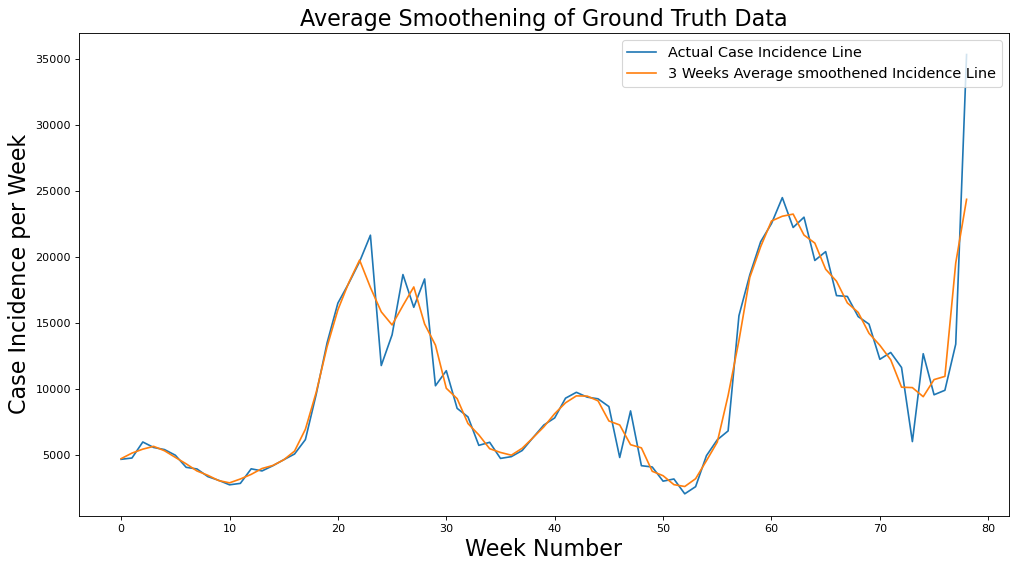

In [688]:
fig, axs = plt.subplots(1,figsize=(15,8 ), dpi=80)
ensemble  = plt.plot(x,orignial_1,label="Actual Case Incidence Line")
#     axs[2].legend((usc,ensemble),('Perfis COPEX','Media'), loc = 'best')
ensemble  = plt.plot(x,state_wise_running_averages[0],label="3 Weeks Average smoothened Incidence Line")
#     axs[2].legend((usc,ensemble),('Perfis COPEX','Media'), loc = 'best')
leg1 = plt.legend(loc='upper right',prop={'size': 13})

plt.title("Average Smoothening of Ground Truth Data", fontsize = 20)

plt.ylabel("Case Incidence per Week",fontsize = 20)

plt.xlabel("Week Number",fontsize = 20)
leg1 = plt.legend(loc='upper right',prop={'size': 13})

if export_visualizations:
    plt.savefig(Visualization_path+"Average_smoothening_demo.png")
else:
    plt.show()

## Generating Shapelets for Actual Covid-19 Case/Death Incidence - Ground Truth

In [689]:

shapelet_Combinatinos = list(combinations(shapelet_standard_array,2))

shapelet_Combinatinos_names = list(combinations(shapelet_standard_names,2))



pairwise_dissimilairty = {}
for i in range(len(shapelet_Combinatinos_names)):
    vector1 = shapelet_Combinatinos[i][0]
    vector2 = shapelet_Combinatinos[i][1]
    pairwise_dissimilairty[shapelet_Combinatinos_names[i]]  = spatial.distance.cosine(vector1,vector2)
    
    

overall_sum = sum(pairwise_dissimilairty.values())
for k,v in pairwise_dissimilairty.items():
    pairwise_dissimilairty[k] = v/overall_sum
    

In [692]:

import pickle

with open(pickle_path+'ShapeLet_loss_weight.pickle', 'wb') as handle:
    pickle.dump(pairwise_dissimilairty, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [693]:
### Lets Generate for each week/ state, running vectors of size 5

In [694]:
ShapeLet_Dictionary_State_level = {}

Shapelet_dict_actual_state_week_vector_label = {}

for keys in running_average.keys():
#     print(keys)
    State_name = keys
    running_avg = running_average[State_name]



    running_avg_vectors = []
    for i in range(len(running_avg)):
        if i<len(running_avg)-future_weeks:
            if i<=history_weeks:
                vec = running_avg[i-0:i+future_weeks+history_weeks]
            else:
                vec = running_avg[i-history_weeks:i+future_weeks]
            vec1 = [w[1] for w in vec]
            assert len(vec1)==Shapelet_length,"Size of vector not equal to standard shapelet size"


            week_nbr = vec[0][0]
            running_avg_vectors.append((week_nbr,vec1[0],vec1))

    dicy_state = Shapelet_dict_actual_state_week_vector_label.get(State_name,{})
#     print(dicy_state)
#     assert len(vector[2])==Shapelet_length,"Size of vector not equal to standard shapelet size"
    scenarios_list_pearson_perason = [(vector[0],vector[1],return_best_shapelet_pearson(vector[2]),return_all_shapelet_pearson(vector[2])) for vector in running_avg_vectors]
    
    for vector in scenarios_list_pearson_perason:
        dicy_state[vector[0]] = [(vector[3],vector[2])]
    Shapelet_dict_actual_state_week_vector_label[State_name] = dicy_state
        

    ShapeLet_Dictionary_State_level[keys] = scenarios_list_pearson_perason

    ## Actual Covid tally plot validation 

    week_nbr_plt = [w[0] for w in scenarios_list_pearson_perason]
    actual_count_plt = [w[1] for w in scenarios_list_pearson_perason]
    labels_plt = [w[2] for w in scenarios_list_pearson_perason]





/Users/satwant/Documents/Anaconda3/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/satwant/Documents/Anaconda3/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [695]:
#import pickle

with open(pickle_path+'ShapeLet_Dictionary_State_level_actual.pickle', 'wb') as handle:
    pickle.dump(ShapeLet_Dictionary_State_level, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [696]:
#import pickle

with open(pickle_path+'Shapelet_dict_actual_state_week_vector_label.pickle', 'wb') as handle:
    pickle.dump(Shapelet_dict_actual_state_week_vector_label, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Load Models Data and apply Shapelets method on it

In [697]:
if Data_refresh==1:
    print("Data refresh process begins")
    if Runtype=="Cases":
        root_tmp = glob.glob(Input_path+"Input_Files/Model_Forecasts_Data/US-COVID/state-case/*")
    else:
        root_tmp = glob.glob(Input_path+"Input_Files/Model_Forecasts_Data/US-COVID/state-death/*")

    root = [w for w in root_tmp if w.split("/")[-1] not in Ignore_model_list]

    len(root)

    model_lookup = {}


    for l in root[:]:
        model_lookup1 = {}
    #     try:
        df_master = pd.DataFrame()
    #     print(l)

        subroot = glob.glob(l+"/*.csv")
        for k in subroot:
    #         print(k)
    #         print(k)
            df = pd.read_csv(k).fillna(0)

            US_total_1 = pd.DataFrame(df.sum(axis=0))

            df = pd.concat([df,US_total_1.T])
            df.loc[df["State"].str.len() > 100,"State"] = "United States"

            temp = re.findall(r'\d+', k.split("/")[-1])[-1]

            res = temp
            model_lookup1[res] = df
        model_lookup[l.split("/")[-1]] = model_lookup1

    print("Total Number of Models in Repository ---> {}".format(len(model_lookup.keys())))

    qualifying_threshold = 60

    Eligible_Model_week_State_forecasts= {}

    for key, val in model_lookup.items():
        if len(val)>qualifying_threshold:
            Eligible_Model_week_State_forecasts[key] = val

    #import pickle

    with open(pickle_path+'Eligible_Model_week_State_forecasts.pickle', 'wb') as handle:
        pickle.dump(Eligible_Model_week_State_forecasts, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Data Refresh process for Model Forecasts completed")
else:
    print("Using Pickle file already gnerated in the past")
    file = open(pickle_path+'Eligible_Model_week_State_forecasts.pickle','rb')
    Eligible_Model_week_State_forecasts = pickle.load(file)

    print("Total Number of Eligible Models in Repository ---> {}".format(len(Eligible_Model_week_State_forecasts.keys())))


Using Pickle file already gnerated in the past
Total Number of Eligible Models in Repository ---> 17


In [698]:
history_weeks

1

In [699]:
future_weeks

4

In [700]:
Shapelet_length

5

In [701]:
Shapelet_dict_actual_state_week_vector_label['California'].keys()

dict_keys([164, 171, 178, 185, 192, 199, 206, 213, 220, 227, 234, 241, 248, 255, 262, 269, 276, 283, 290, 297, 304, 311, 318, 325, 332, 339, 346, 353, 360, 367, 374, 381, 388, 395, 402, 409, 416, 423, 430, 437, 444, 451, 458, 465, 472, 479, 486, 493, 500, 507, 514, 521, 528, 535, 542, 549, 556, 563, 570, 577, 584, 591, 598, 605, 612, 619, 626, 633, 640, 647, 654, 661, 668, 675])

In [702]:
State_model_Week_vector_shapelet_Actual_dict = {}

model_wise_master_db =[]

ddd = 0

impu = 0 

model_cnt = 0


for key_outer,value_outer in Eligible_Model_week_State_forecasts.items():
#     if key_outer!='USC_SI_kJalpha':
#         continue
    model_lookup1 = value_outer
    iters = list(model_lookup1.keys())
    for key in iters:
#         if key!='327':
#             continue
        
        data = model_lookup1[key]
        cols = list(data.columns)
        
            
        start_index = cols.index("State")
        forecast_start = start_index+2
        forecast_end = forecast_start+4
        valid_columns = [cols[start_index]]+cols[forecast_start:forecast_end]
        if len(cols)<=6:
            valid_columns = [cols[start_index]]+cols[start_index+1:]
        forecast_input = data[valid_columns]
        state_iterations = list(forecast_input['State'].values)

        for state in state_iterations:
            if state in Ignore_State_list:
                continue
#             if state!='California':
#                 continue
            try:
                predictions_raw = forecast_input[forecast_input['State']==state][:].values[0][1:]
            except:
                print(key_outer,key,state)
                predictions_raw = forecast_input[forecast_input['State']=="Virgin Islands, U.S."][:].values[0][1:]
            week_num = int(key)
            mod = week_num%7
            target = 3
            add = target-mod
            lookup_key = add+week_num
            try:
                actual_covid_tally_records = Actual_covid_tally_dict[state]
            except:
                actual_covid_tally_records = Actual_covid_tally_dict["Virgin Islands"]
            week_num = int(key)
            if history_weeks>0:
                ddd+=1
#                 print("History >0")
                mod = week_num%7
                target = 3
                add = target-mod

                lookup_key = add+week_num
                history_vector = []
                for h1 in range(history_weeks):
                    history1 = actual_covid_tally_records.get(lookup_key-7*(h1+1),None)
                    if history1 is None:
                        history_vector.append(predictions_raw[0])
                        impu+=1
#                         print("imputation performed")
                    else:
                        history_vector.append(history1)
                history_vector.reverse()
                predictions_vector_tmp = history_vector+list(predictions_raw) 
                predictions_vector_tmp_1 = predictions_vector_tmp[:-1]+[predictions_vector_tmp[-1]+0.00001]

    #             try:
    #             print(state,lookup_key,key_outer)
                if predictions_vector_tmp[0] is None:
                    predictions_vector_tmp = [predictions_vector_tmp[1]]+predictions_vector_tmp[1:]

                if len(predictions_vector_tmp)!=Shapelet_length:
#                     print("Skipped Evaluation")
                    continue
                    
    #             print(lookup_key)
    #             print(key)
    #             print("Vector Used : ",predictions_vector_tmp)
            else:
                predictions_vector_tmp = list(predictions_raw[:])
                if len(predictions_vector_tmp)!=Shapelet_length:
                    print("Skipped Evaluation",week_num,state,key_outer)
                    
                    continue
            if key_outer=='FH_COVIDhub_baseline':
#                 print(key,state,predictions_vector_tmp)
                continue
            state_dict = State_model_Week_vector_shapelet_Actual_dict.get(state,{})
            
            state_dict_model_dict = state_dict.get(lookup_key,{})
            try:
                Actual_shapelte_5X1_vector = Shapelet_dict_actual_state_week_vector_label[state][lookup_key][0]
            except:
                Actual_shapelte_5X1_vector = [None]*Shapelet_length
#                 print("exception",key,state,predictions_vector_tmp)
                continue
            shape_1 = return_best_shapelet_pearson(predictions_vector_tmp)
#             try:
            state_dict_model_dict[key_outer] = [((return_all_shapelet_pearson(predictions_vector_tmp),Actual_shapelte_5X1_vector,),shape_1)]
#             except:
                
            state_dict[lookup_key] = state_dict_model_dict
            
            State_model_Week_vector_shapelet_Actual_dict[state] = state_dict
#             print("Shape Predicted: ",shape)
            model_wise_master_db.append((state,lookup_key,key_outer,shape_1))
#             except:
#             print(state,lookup_key,key_outer,shape)


# 612 - USC - what



In [703]:
# for key,val in State_model_Week_vector_shapelet_Actual_dict['California'].items():
#     for keay1,val1 in val.items():
#         if key1=='FH_COVIDhub_baseline':
#             print(key,val1)
    

In [704]:
print("Total Number of Iterations {}".format(ddd))
print("Total number of impuations {}".format(impu))

Total Number of Iterations 2432
Total number of impuations 16


In [705]:
import pickle

with open(pickle_path+'State_model_Week_vector_shapelet_Actual_dict.pickle', 'wb') as handle:
    pickle.dump(State_model_Week_vector_shapelet_Actual_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [706]:
Actual_covid_tuples = []

for key, val1 in ShapeLet_Dictionary_State_level.items():
    for val in val1:
        Actual_covid_tuples.append((key,val[0],val[1],val[2]))

In [707]:
Actual_covid_df = pd.DataFrame(Actual_covid_tuples)

In [708]:
Actual_covid_df.columns  = ['State','Week_number','Covid Count','Label_Actual']

In [709]:
Actual_covid_df['key'] = Actual_covid_df['State']+"_"+Actual_covid_df['Week_number'].astype("str")


In [710]:

model_wise_master_df = pd.DataFrame(model_wise_master_db)

model_wise_master_df.columns = ['State','Week Number','Model_Name','Predicted']

model_wise_master_df['key'] = model_wise_master_df['State']+"_"+model_wise_master_df['Week Number'].astype("str")


In [711]:

merged_df_models_actual = model_wise_master_df.merge(Actual_covid_df,how='inner',on='key')


In [712]:
print(Actual_covid_df['Label_Actual'].value_counts())

Dec          1375
Surge         842
Inc           732
Peaking       593
Near Peak     552
Flat          181
Name: Label_Actual, dtype: int64


In [713]:
print(model_wise_master_df['Predicted'].value_counts()/model_wise_master_df['Model_Name'].nunique())

Dec          70.2500
Peaking      26.2500
Inc          13.8750
Near Peak    12.2500
Surge        10.3125
Flat          5.3125
Name: Predicted, dtype: float64


In [714]:
merged_df_models_actual.to_csv(Ouput_path+"Shapelet_model_evaluation_cases.csv")

In [715]:


State_weel_ScenarioWise = merged_df_models_actual.groupby(['State_x',"Week Number","Predicted","Label_Actual"]).agg(Count = ("Week_number","count")).reset_index()




State_week_rolllup = merged_df_models_actual.groupby(['State_x',"Week Number","Label_Actual"]).agg(Count_overall = ("Week_number","count"),Covid_case_count= ("Covid Count","sum")).reset_index()


Summarized_Results = State_weel_ScenarioWise.merge(State_week_rolllup,on=['State_x','Week Number'],how="inner").drop(["Label_Actual_y"],axis=1)


Summarized_Results['Probability of Class'] = Summarized_Results['Count']/Summarized_Results['Count_overall']


In [716]:

Summarized_Results["rank"] = Summarized_Results.groupby(["State_x","Week Number"])["Probability of Class"].rank("dense", ascending=False)


In [717]:
plot_results_softmax = Summarized_Results[Summarized_Results['rank']==1]

In [718]:
State_Iteration = list(plot_results_softmax.State_x.unique())

In [719]:
import pandas as pd

In [720]:
merged_df_models_actual = pd.read_csv(Ouput_path+"Shapelet_model_evaluation_cases.csv")

In [721]:
Master_df_actual_VS_Model_Agrrement = pd.DataFrame()

a = set()
for State_name in State_model_Week_vector_shapelet_Actual_dict.keys():
    if State_name in Ignore_State_list:
        continue



    State_Week_Model_name_Cosine_match_cases = {}
    # State_name = 'California'



    # California_debug_actual = Shapelet_dict_actual_state_week_vector_label[State_name]

    California_debug_model =  State_model_Week_vector_shapelet_Actual_dict[State_name]


    generate_tuple = []

    state_dict = State_Week_Model_name_Cosine_match_cases.get(State_name,{})


    for weeks, model_level in California_debug_model.items():
#         if weeks>585:
#             continue
        week_dict = state_dict.get(weeks,{})
        
        

        for model,data_vector in model_level.items():
#             if model!='FH_COVIDhub_ensemble':
#                 pass
    #         print(data_vector)
            datset1 = data_vector[0][0][0]
            dataset2 = data_vector[0][0][1][0]
    #         print(data_vector[0][0][1][1])
    #         print(data_vector[0][1])
            model_val = week_dict.get(model,None)
            if model_val is None:
                try:
                    week_dict[model] =(data_vector[0][1],data_vector[0][0][1][1],round(cosine_sim(datset1,dataset2),4))

                    generate_tuple.append([weeks,model,data_vector[0][1],data_vector[0][0][1][1],round(cosine_sim(datset1,dataset2),4)])
        #             print()
        #             print(weeks,model,cosine_sim(datset1,dataset2))
                except:
#                     print(weeks)
                    a.add(weeks)

                    pass
    #                 print(weeks,model,dataset2)
        state_dict[weeks] = week_dict

    State_Week_Model_name_Cosine_match_cases[State_name] = state_dict

    Model_actual_cosine_Agrremen_df = pd.DataFrame(generate_tuple)


    Model_actual_cosine_Agrremen_df.columns = ['Week Number',"Model Name","Predicted Label","True Label","Cosine Similarty"]
    
    Model_actual_cosine_Agrremen_df['State'] = State_name

    Master_df_actual_VS_Model_Agrrement = pd.concat([Master_df_actual_VS_Model_Agrrement,Model_actual_cosine_Agrremen_df],axis=0)
    

In [722]:
Master_df_actual_VS_Model_Agrrement

,Week Number,Model Name,Predicted Label,True Label,Cosine Similarty,State
0,591,FH_RobertWalraven_ESG,Dec,Dec,0.9902,California
1,591,FH_CU_nochange,Dec,Dec,0.9878,California
2,591,FH_CU_scenario_low,Dec,Dec,0.9822,California
3,591,FH_JHUAPL_Bucky,Peaking,Dec,-0.9944,California
4,591,FH_JHU_IDD_CovidSP,Surge,Dec,-0.9947,California
...,...,...,...,...,...,...
1017,626,FH_CEID_Walk,Dec,Dec,0.9910,Florida
1018,626,USC_SI_kJalpha,Dec,Dec,0.9983,Florida
1019,626,FH_BPagano_RtDriven,Dec,Dec,0.9999,Florida
1020,626,FH_COVIDhub_ensemble,Dec,Dec,0.9985,Florida


In [723]:
Model_actual_cosine_Agrremen_df

,Week Number,Model Name,Predicted Label,True Label,Cosine Similarty,State
0,591,FH_RobertWalraven_ESG,Dec,Dec,0.9996,Florida
1,591,FH_CU_nochange,Dec,Dec,0.9999,Florida
2,591,FH_CU_scenario_low,Dec,Dec,0.9999,Florida
3,591,FH_JHUAPL_Bucky,Dec,Dec,0.9989,Florida
4,591,FH_JHU_IDD_CovidSP,Surge,Dec,-0.9792,Florida
...,...,...,...,...,...,...
1017,626,FH_CEID_Walk,Dec,Dec,0.9910,Florida
1018,626,USC_SI_kJalpha,Dec,Dec,0.9983,Florida
1019,626,FH_BPagano_RtDriven,Dec,Dec,0.9999,Florida
1020,626,FH_COVIDhub_ensemble,Dec,Dec,0.9985,Florida


In [724]:
Master_df_actual_VS_Model_Agrrement.to_csv(Ouput_path+"Shapelet_model_evaluation_cases_cosine_modelVS_Actual.csv")

In [725]:
Master_df_actual_VS_Model_Agrrement


MeanSimilarityModels_Actual = Master_df_actual_VS_Model_Agrrement.groupby(['State','Week Number']).agg(Mean_Similarity=("Cosine Similarty","mean")).reset_index()


In [726]:

best_model_label_df = Master_df_actual_VS_Model_Agrrement.groupby(['True Label','Model Name']).agg(Mean_Score=("Cosine Similarty","mean")).reset_index()


## NC2 conbinations for checking agreement between models

In [727]:
State_model_Week_vector_shapelet_Actual_dict.keys()

dict_keys(['California', 'Florida'])

In [728]:
Master_df_Model_VS_Model_Agrrement = pd.DataFrame()

for State_name in State_model_Week_vector_shapelet_Actual_dict.keys():
    if State_name in Ignore_State_list:
        continue



    State_Week_Model_name_Cosine_match_cases = {}
    # State_name = 'California'



    # California_debug_actual = Shapelet_dict_actual_state_week_vector_label[State_name]

    California_debug_model =  State_model_Week_vector_shapelet_Actual_dict[State_name]


    generate_tuple = []

    state_dict = State_Week_Model_name_Cosine_match_cases.get(State_name,{})


    for weeks, model_level in California_debug_model.items():
#         if weeks>585:
#             continue
        week_dict = state_dict.get(weeks,{})
        
        

        for model1,data_vector1 in model_level.items():
            for model2,data_vector2 in model_level.items():
                
            
    #         print(data_vector)
                datset1 = data_vector1[0][0][0]
                dataset2 = data_vector2[0][0][1][0]
    #             model_val = week_dict.get(model,None)
    #             if model_val is None:
        #             try:
    #             week_dict[model] =(data_vector[0][1],data_vector[0][0][1][1],round(cosine_sim(datset1,dataset2),4))
                try:
                    if dataset2 is not None:
                        if datset1 is not None:
                            if model1!=model2:

                                if model1>model2:
                                    generate_tuple.append([weeks,model1,model2,round(cosine_sim(datset1,dataset2),4)])
                                else:
                                    generate_tuple.append([weeks,model2,model1,round(cosine_sim(datset1,dataset2),4)])
                except:
                    print([weeks,model2,model1,datset1,dataset2])
        #             print()
        #             print(weeks,model,cosine_sim(datset1,dataset2))
    #             except:

    #                 pass
    #                 print(weeks,model,dataset2)
#         state_dict[weeks] = week_dict

#     State_Week_Model_name_Cosine_match_cases[State_name] = state_dict

    Model_actual_cosine_Agrremen_df = pd.DataFrame(generate_tuple)


    Model_actual_cosine_Agrremen_df.columns = ['Week Number',"Model Name1","Model Name2","Cosine Similarty"]
    
    Model_actual_cosine_Agrremen_df['State'] = State_name

    Master_df_Model_VS_Model_Agrrement = pd.concat([Master_df_Model_VS_Model_Agrrement,Model_actual_cosine_Agrremen_df],axis=0)
    

In [729]:
Master_df_Model_VS_Model_Agrrement = Master_df_Model_VS_Model_Agrrement.drop_duplicates()

In [730]:
# Master_df_Model_VS_Model_Agrrement.shape

In [731]:

MeanSimilarityModels = Master_df_Model_VS_Model_Agrrement.groupby(['State','Week Number']).agg(Mean_Similarity=("Cosine Similarty","mean")).reset_index()


In [732]:
MeanSimilarityModels.to_csv(Ouput_path+"MeanSimilarity_within_models_cases.csv")

In [733]:
# len(MeanSimilarityModels)

## Ensemble Model Generation using mean pearson Vector



In [734]:
Number_of_shapelets

6

In [735]:
State_list_plotting = [w for w in list(Master_df_actual_VS_Model_Agrrement.State.unique()) if w not in Ignore_State_list]

State_week_avg_ensemble = {}
for state in State_list_plotting:
    Week_averge_cosine = {}

    for key, vale in State_model_Week_vector_shapelet_Actual_dict[state].items():
        vec1 = []
    #     actual_vec = []

        for k1,v1 in vale.items():
    #         print(v1)
    #         print(v1[0][0][0])
            vec1.append(v1[0][0][0])
            actual_vec = v1[0][0][1][0]
        denom = len(vec1)
        summation_list = []
        for i in range(Number_of_shapelets):
            avg_shape_cosin = (sum([w[i] for w in vec1]))/denom
            summation_list.append(avg_shape_cosin)
#         a = (sum([w[0] for w in vec1]))/denom
#         b = (sum([w[1] for w in vec1]))/denom
#         c=(sum([w[2] for w in vec1]))/denom
#         d=(sum([w[3] for w in vec1]))/denom
#         e=(sum([w[4] for w in vec1]))/denom
#         f=(sum([w[5] for w in vec1]))/denom
        try:
            Week_averge_cosine[key] = cosine_sim(actual_vec,summation_list)
        except:
            print(key)
    State_week_avg_ensemble[state] =Week_averge_cosine 



In [736]:
def date_formatting(week_nbr):
# week_nbr = 164
    t = 'Jan 22 2020'
    format = '%b %d %Y'
    now = datetime.strptime(t,format)
    after = now + timedelta(days = int(week_nbr))
    return after.date().strftime("%m/%d/%Y")

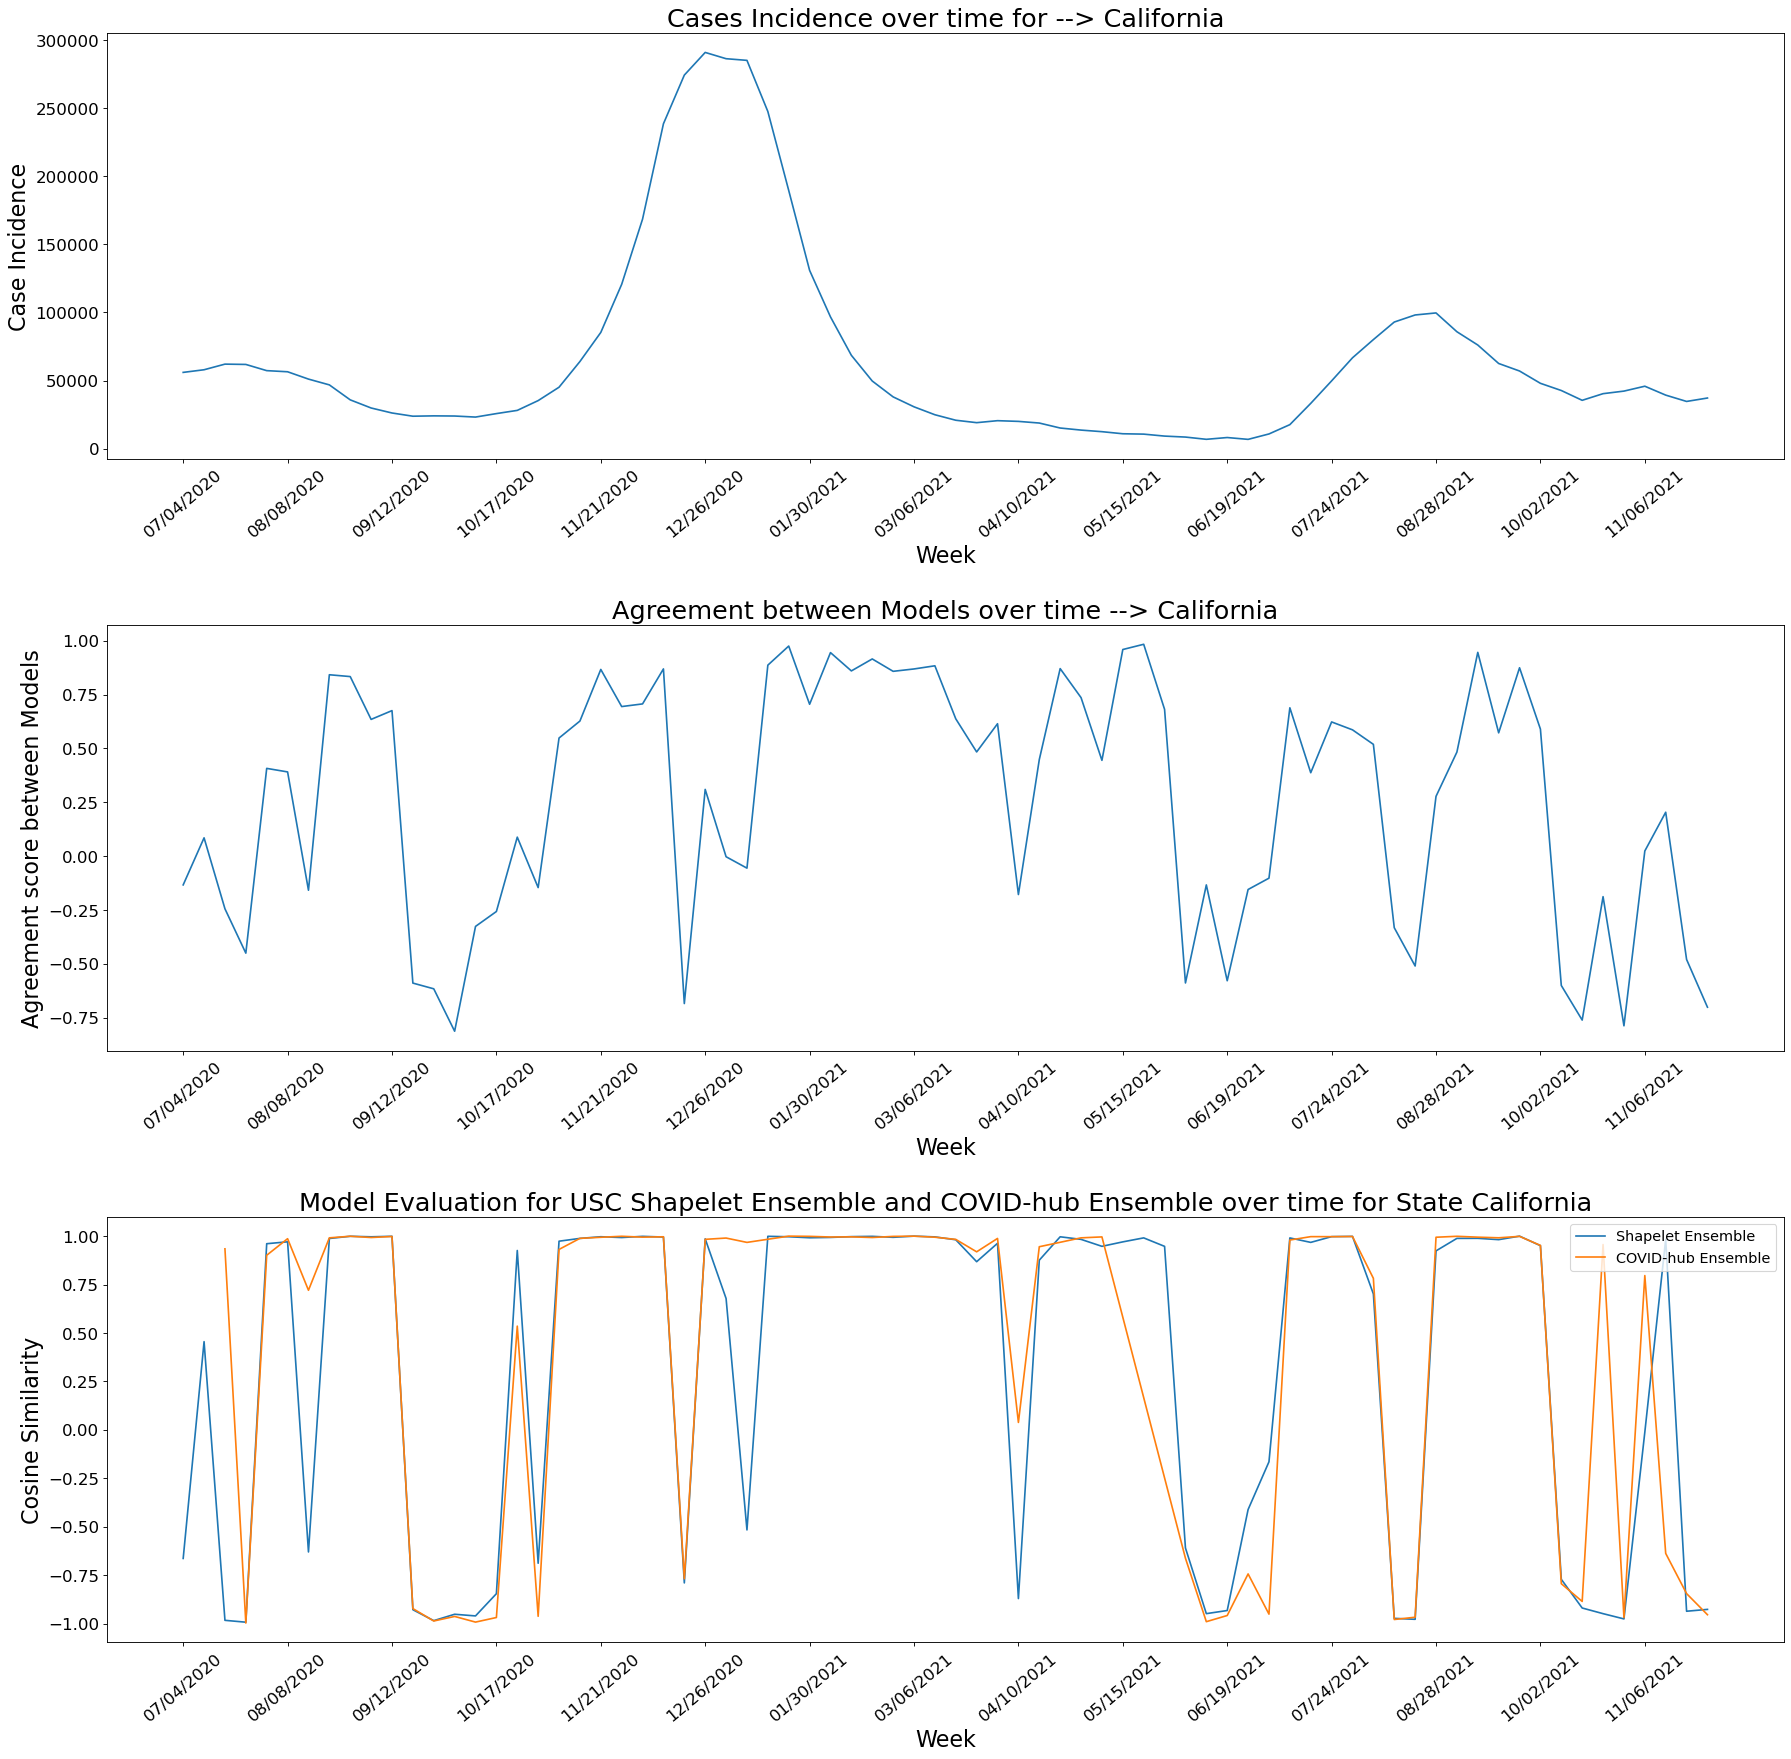

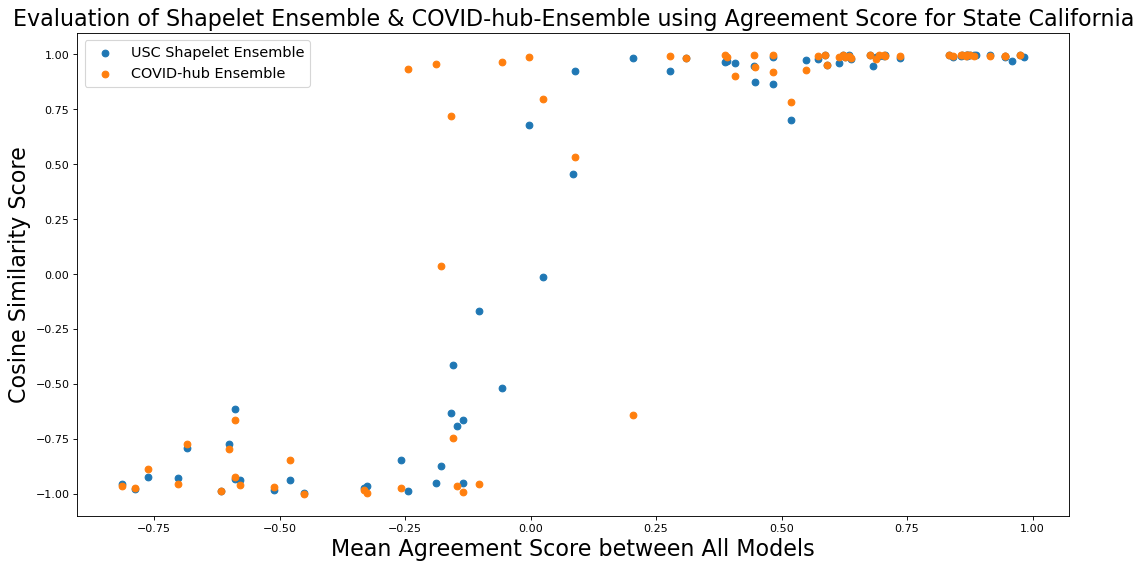

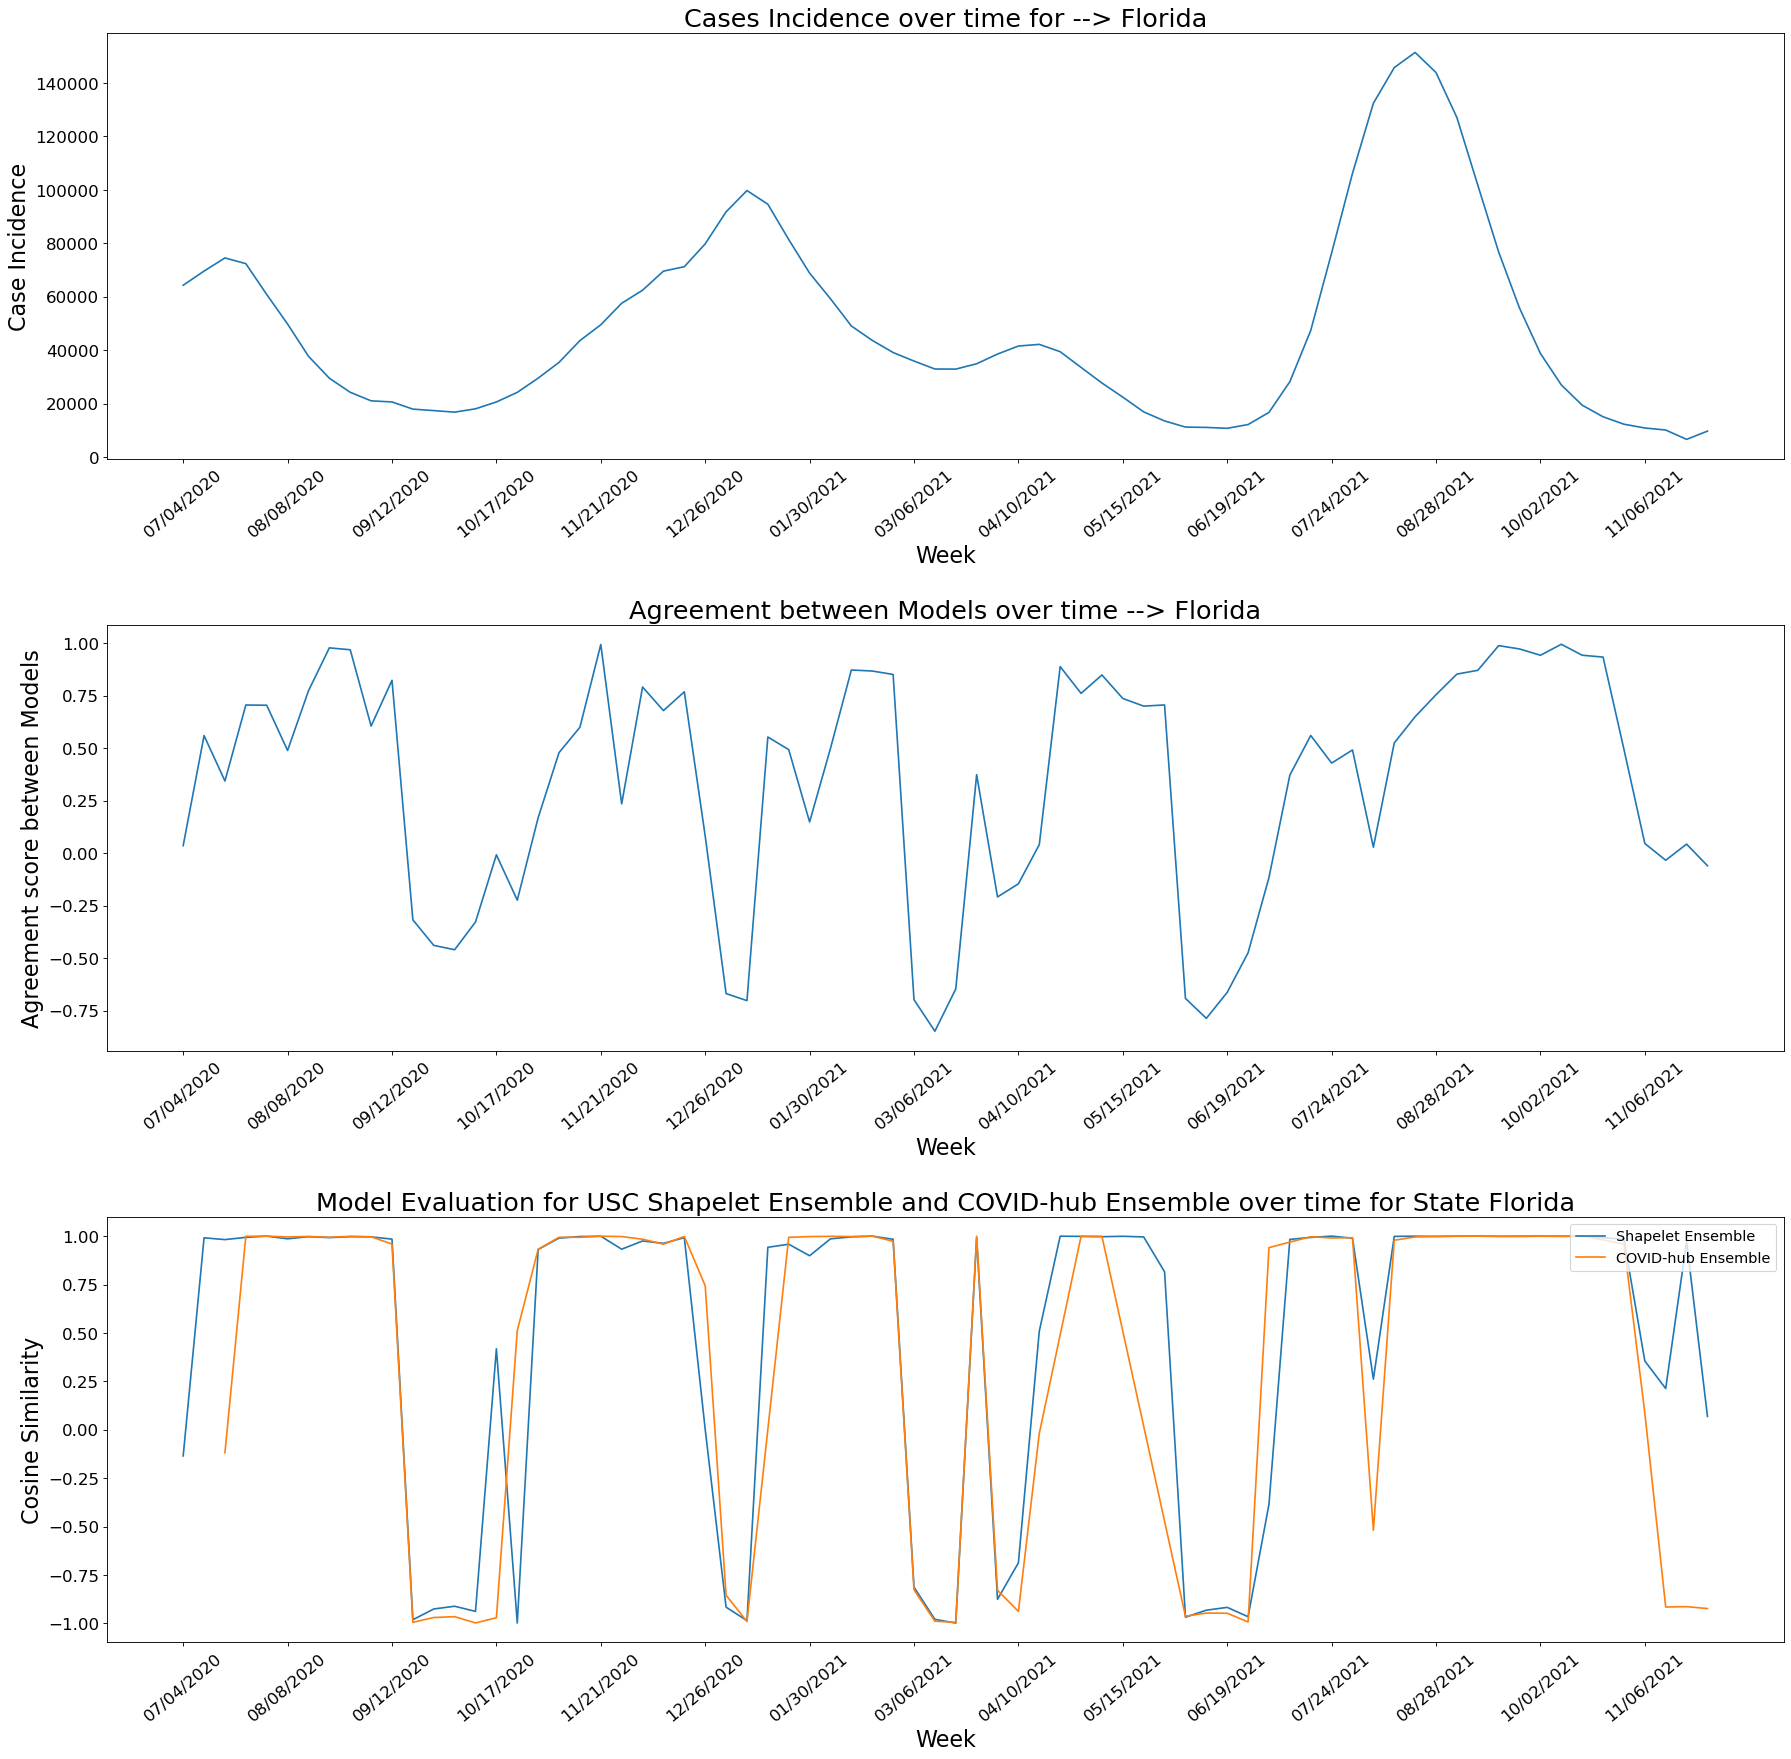

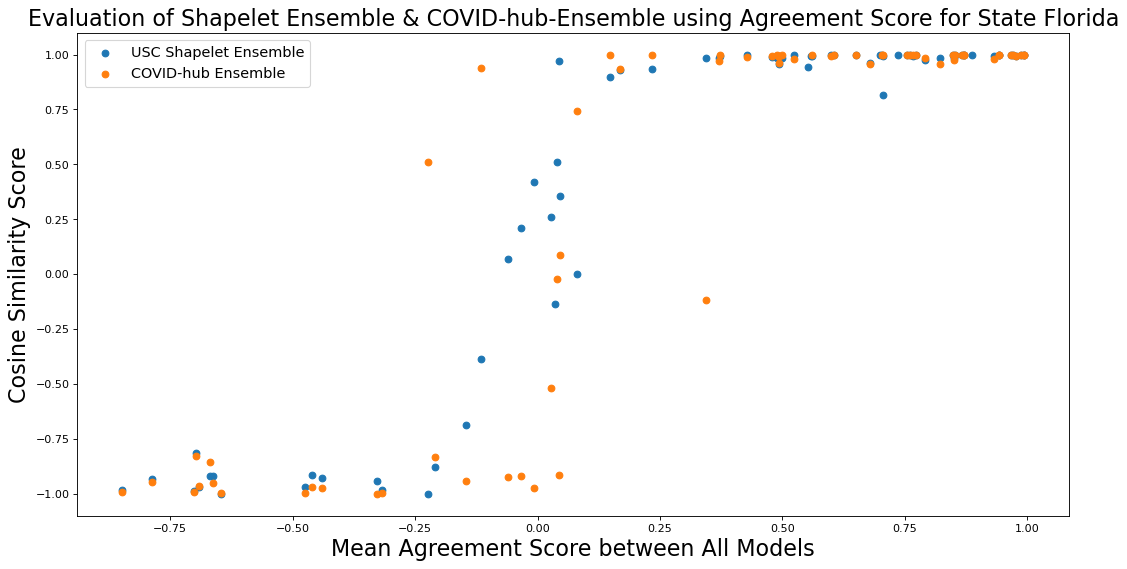

In [737]:
state_lst = State_list_plotting[:]

for state in state_lst:
    
    scatter_plot_x = None
    
    Scatter_plot_y1 = None
    
    Scatter_plot_y2 = None
    
    model = "USC shapelet-ensemble"
#     if state not in ['California','United States']:
#         continue
    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    fig, axs = plt.subplots(3,figsize=(25,24 ), dpi=80)

    fig.tight_layout(pad=13.0)

    subset_data = plot_results_softmax[plot_results_softmax['State_x']==state].drop_duplicates(['Week Number','Label_Actual_x'])
    Actual_Case_cnt = (subset_data['Covid_case_count']/subset_data['Count_overall']).to_list()

    Predicted_label = subset_data['Predicted'].to_list()

    Actual_Label = subset_data['Label_Actual_x'].to_list()

    Week_nbr = subset_data['Week Number'].to_list()
    str_week_int = []
    str_week = []
    for i in range(0,len(Week_nbr),5):
        str_week_int.append(Week_nbr[i])
        str_week.append(date_formatting(Week_nbr[i]))

#         print(len(Week_nbr))

    axs[0].plot(Week_nbr,Actual_Case_cnt)
    axs[0].set_xlabel('Week', fontsize = 20)
    axs[0].set_ylabel('Case Incidence', fontsize = 20)
    
    
    
    
#     axs[0].set(xlabel="Week", ylabel="Covid Case Count")

    axs[0].set_title(Runtype+" Incidence over time for --> "+state,fontsize=23)
    axs[0].set_xticks(str_week_int)
    axs[0].set_xticklabels(str_week,rotation=40,fontsize=15)
    axs[0].yaxis.set_tick_params(labelsize=15)
#     axs[0].set_yticklabels(fontsize=13)
#     axs[0].set_yticks(Actual_Case_cnt)
#     axs[0].set_yticklabels(Actual_Case_cnt,fontsize=13)
    
    
    subset = MeanSimilarityModels[MeanSimilarityModels['State']==state]

    week_nbrs = list(subset['Week Number'].values)

    meanS_miliary = subset['Mean_Similarity'].values
    
    axs[1].plot(week_nbrs,meanS_miliary)
    axs[1].set_xlabel('Week', fontsize = 20)
    axs[1].set_ylabel('Agreement score between Models', fontsize = 20)
    scatter_plot_x = [week_nbrs,meanS_miliary]

#     axs[1].set(xlabel="Week Number", ylabel="Agreement score between Models")

    axs[1].set_title("Agreement between Models over time --> "+state,fontsize=23)
    
    str_week_int = []
    str_week = []
    for i in range(0,len(week_nbrs),5):
        str_week_int.append(week_nbrs[i])
        str_week.append(date_formatting(week_nbrs[i]))
    axs[1].set_xticks(str_week_int)
    axs[1].set_xticklabels(str_week,rotation=40,fontsize=15)
    axs[1].yaxis.set_tick_params(labelsize=15)
    
    


    data = State_week_avg_ensemble.get(state)
    
    x1 = []
    y1 = []
    for k,v in data.items():
        x1.append(k)
        y1.append(v)

    vectors = list(zip(x1,y1))

    vector_sorted = sorted(vectors,key = lambda x : x[0]) 

    x1 = [w[0] for w in vector_sorted ]
    y = [w[1] for w in vector_sorted ]
    Week_nbr = x1

    usc = axs[2].plot(x1,y,label='Shapelet Ensemble')
    scatter_plot_y1 = [x1,y]

    str_week_int = []
    str_week = []
    for i in range(0,len(Week_nbr),5):
        str_week_int.append(Week_nbr[i])
        str_week.append(date_formatting(Week_nbr[i]))
    axs[2].set_xticks(str_week_int)
    axs[2].set_xticklabels(str_week,rotation=40,fontsize=15)
    axs[2].yaxis.set_tick_params(labelsize=15)

    axs[2].set_xlabel('Week', fontsize = 20)
    axs[2].set_ylabel('Cosine Similarity', fontsize = 20)
    
    
#     usc = axs[2].set(xlabel="Week", ylabel="Cosine Similarity",label = "USC Shapelet Ensemble")

    axs[2].set_title("Model Evaluation for USC Shapelet Ensemble and COVID-hub Ensemble over time for State {}".format(state),fontsize=23)
#         plt.show()

    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    subset_1 = subset[subset['Model Name']=='FH_COVIDhub_ensemble']
    
    x1 = subset_1['Week Number'].values
    
    y1 = subset_1['Cosine Similarty'].values
    
    
    vectors = list(zip(x1,y1))

    vector_sorted = sorted(vectors,key = lambda x : x[0]) 

    x = [w[0] for w in vector_sorted ]
    y = [w[1] for w in vector_sorted ]
    Week_nbr = x

    ensemble  = axs[2].plot(x,y,label="COVID-hub Ensemble")
#     axs[2].legend((usc,ensemble),('Perfis COPEX','Media'), loc = 'best')
    leg1 = axs[2].legend(loc='upper right',prop={'size': 13})
    
    if export_visualizations:
        plt.savefig(Visualization_path+"PlotType : "+Runtype+" "+'Model_Evaluation Plot for Limited Models '+state+'.png')
    else:
        plt.show()
    
    scatter_plot_y2 = [x,y]
    scatter_lookup_dic1 = []
    scatter_lookup_dic2 = []


    for i in range(len(scatter_plot_x[0])):
        x_val_weel = scatter_plot_x[0][i]
        x_val = scatter_plot_x[1][i]
        try:
            y_1 = scatter_plot_y1[1][scatter_plot_y1[0].index(x_val_weel)]
            scatter_lookup_dic1.append((x_val,y_1))
            y_2 = scatter_plot_y2[1][scatter_plot_y2[0].index(x_val_weel)]
            scatter_lookup_dic2.append((x_val,y_2))
        except:
            continue

    
    # perform plotting 
# perform plotting 
    fig, axs = plt.subplots(1,figsize=(16,8 ), dpi=80)

    x1 = [w[0] for w in scatter_lookup_dic1]
    y1 = [w[1] for w in scatter_lookup_dic1]


    usc = axs.scatter(x1,y1,label="USC Shapelet Ensemble")

    x2 = [w[0] for w in scatter_lookup_dic2]
    y2 = [w[1] for w in scatter_lookup_dic2]

    covid_ensemble = axs.scatter(x2,y2,label="COVID-hub Ensemble")

    leg1 = axs.legend(loc='upper left',prop={'size': 13})

    axs.set_xlabel('Mean Agreement Score between All Models', fontsize = 20)
    axs.set_ylabel('Cosine Similarity Score', fontsize = 20)


    #     usc = axs[2].set(xlabel="Week", ylabel="Cosine Similarity",label = "USC Shapelet Ensemble")

    axs.set_title("Evaluation of Shapelet Ensemble & COVID-hub-Ensemble using Agreement Score for State {}".format(state),fontsize=20)
    if export_visualizations:
        plt.savefig(Visualization_path+"PlotType : "+Runtype+" "+'Evaluation of Shapelet Ensemble & COVID-hub-Ensemble using Agreement Score for State '+state+'.png')
    else:
        plt.show()

    



    

In [738]:
### exhaustive list of states, ignore them during demo

### scatter plot to explain performance difference between shapelet and covid hub ensemble

###  

In [739]:
week_nbr = 164
t = 'Jan 22 2020'
format = '%b %d %Y'
now = datetime.strptime(t,format)
after = now + timedelta(days = week_nbr)
# return after.date().strftime("%m/%d/%Y")

In [740]:
date_formatting(int(week_nbrs[i]))

'11/27/2021'

In [741]:
str_week_int = []
str_week = []
for i in range(0,len(week_nbrs),5):
    str_week_int.append(week_nbrs[i])
    try:
        str_week.append(date_formatting(week_nbrs[i]))
    except:
        print(week_nbrs[i])


In [742]:

Master_df_actual_VS_Model_Agrrement_1 = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State'].isin(State_list_plotting)]


In [743]:
Master_df_actual_VS_Model_Agrrement_2 = Master_df_actual_VS_Model_Agrrement_1.groupby(['State','Model Name']).agg(Mean_Similarity=("Cosine Similarty","mean"),Count_Similarity=("Cosine Similarty","count")).reset_index()


In [744]:
Master_df_actual_VS_Model_Agrrement_2


Master_df_actual_VS_Model_Agrrement_2["rank"] = Master_df_actual_VS_Model_Agrrement_2.groupby(["State"])["Mean_Similarity"].rank("dense", ascending=False)


In [745]:
Master_df_actual_VS_Model_Agrrement_2.sort_values(['rank']).to_csv(Ouput_path+"Model Ranking For Selected_States.csv")

In [746]:
df_top3_models_per_state = Master_df_actual_VS_Model_Agrrement_2[Master_df_actual_VS_Model_Agrrement_2['rank']<4]

In [747]:
Master_df_actual_VS_Model_Agrrement_2.sort_values(['rank','State'])

,State,Model Name,Mean_Similarity,Count_Similarity,rank
0,California,FH_BPagano_RtDriven,0.535846,59,1.0
31,Florida,USC_SI_kJalpha,0.439201,74,1.0
10,California,FH_Karlen_pypm,0.455606,71,2.0
19,Florida,FH_CU_nochange,0.437325,57,2.0
11,California,FH_LANL_GrowthRate,0.445325,63,3.0
26,Florida,FH_Karlen_pypm,0.421124,71,3.0
3,California,FH_CU_nochange,0.384082,57,4.0
30,Florida,FH_UMich_RidgeTfReg,0.394180,59,4.0
8,California,FH_JHUAPL_Bucky,0.374088,64,5.0
18,Florida,FH_COVIDhub_ensemble,0.363125,67,5.0


In [748]:
df2 = df_top3_models_per_state.groupby('State')['Model Name'].apply(list)

In [749]:
model_list = df2.to_dict()

In [750]:
for key,vale in model_list.items():
    print("For the State {} Top 3 performing Models are --> {}".format(key,str(vale)[1:-1]))

For the State California Top 3 performing Models are --> 'FH_BPagano_RtDriven', 'FH_Karlen_pypm', 'FH_LANL_GrowthRate'
For the State Florida Top 3 performing Models are --> 'FH_CU_nochange', 'FH_Karlen_pypm', 'USC_SI_kJalpha'


length of x1 59
length of x11 71


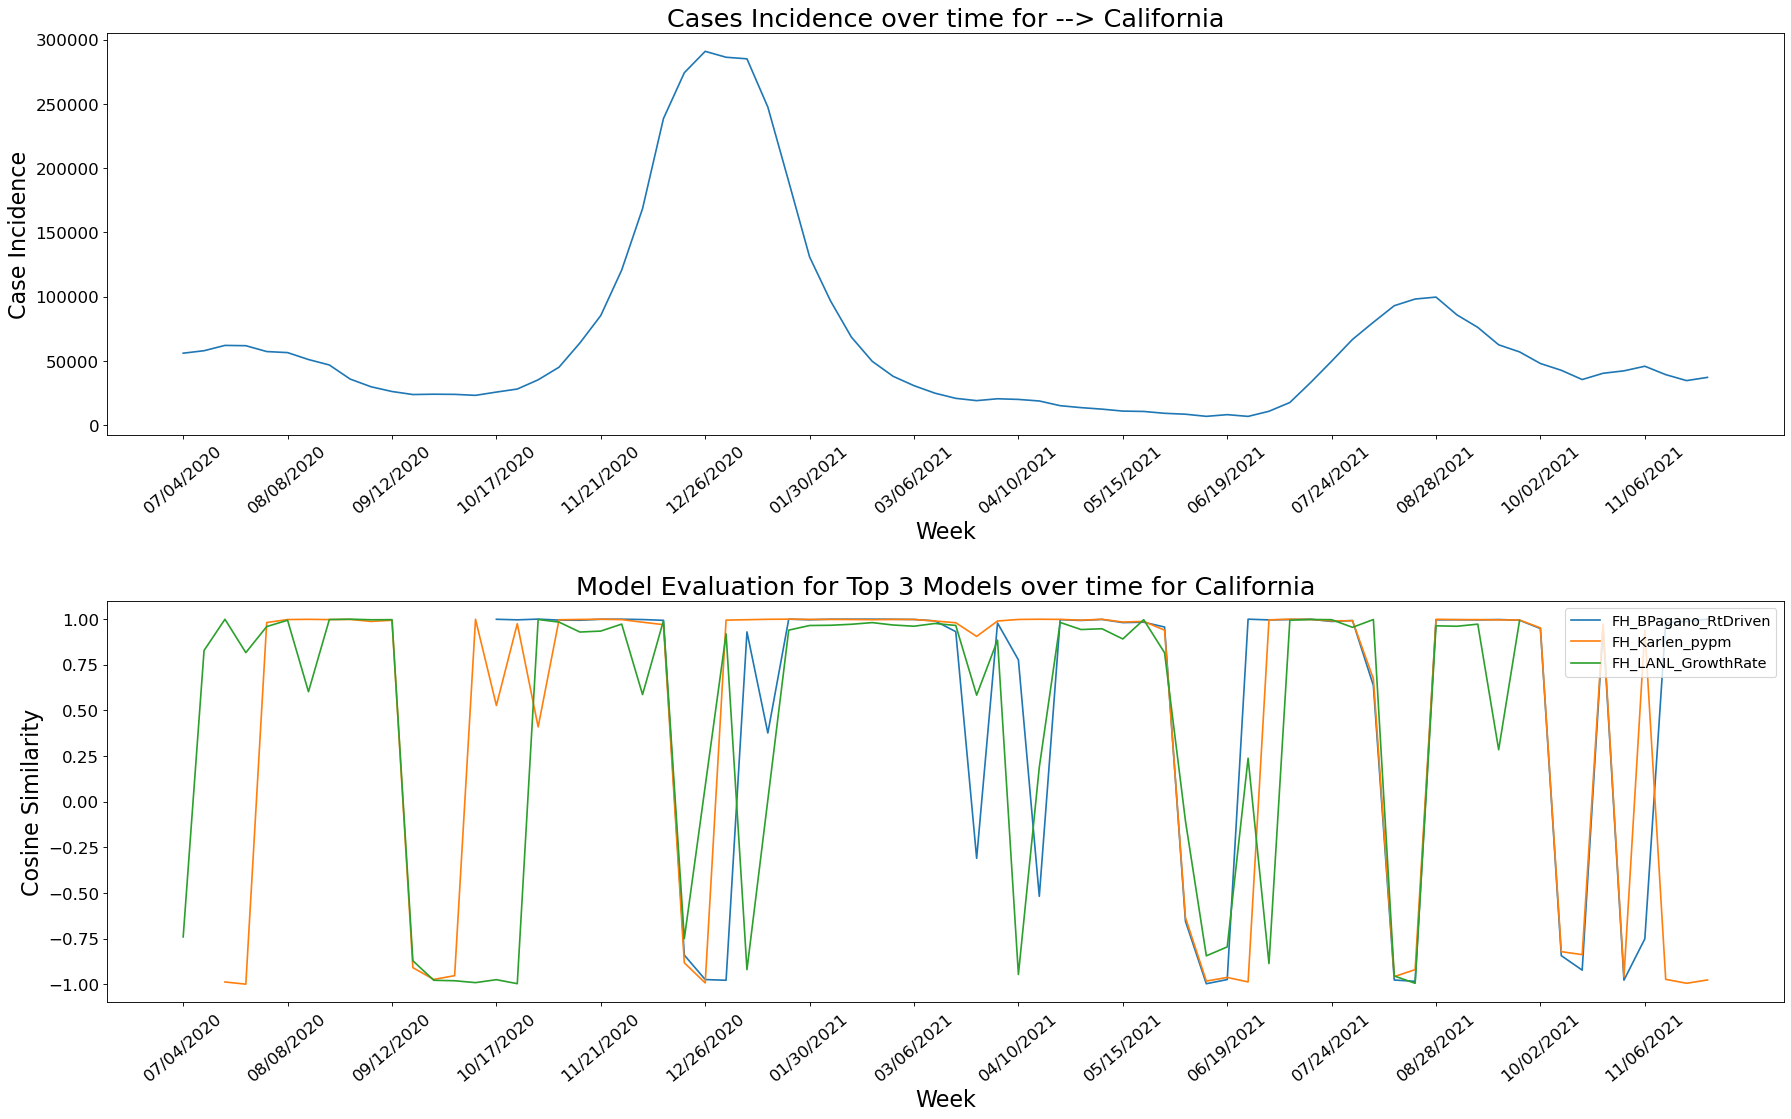

length of x1 57
length of x11 71


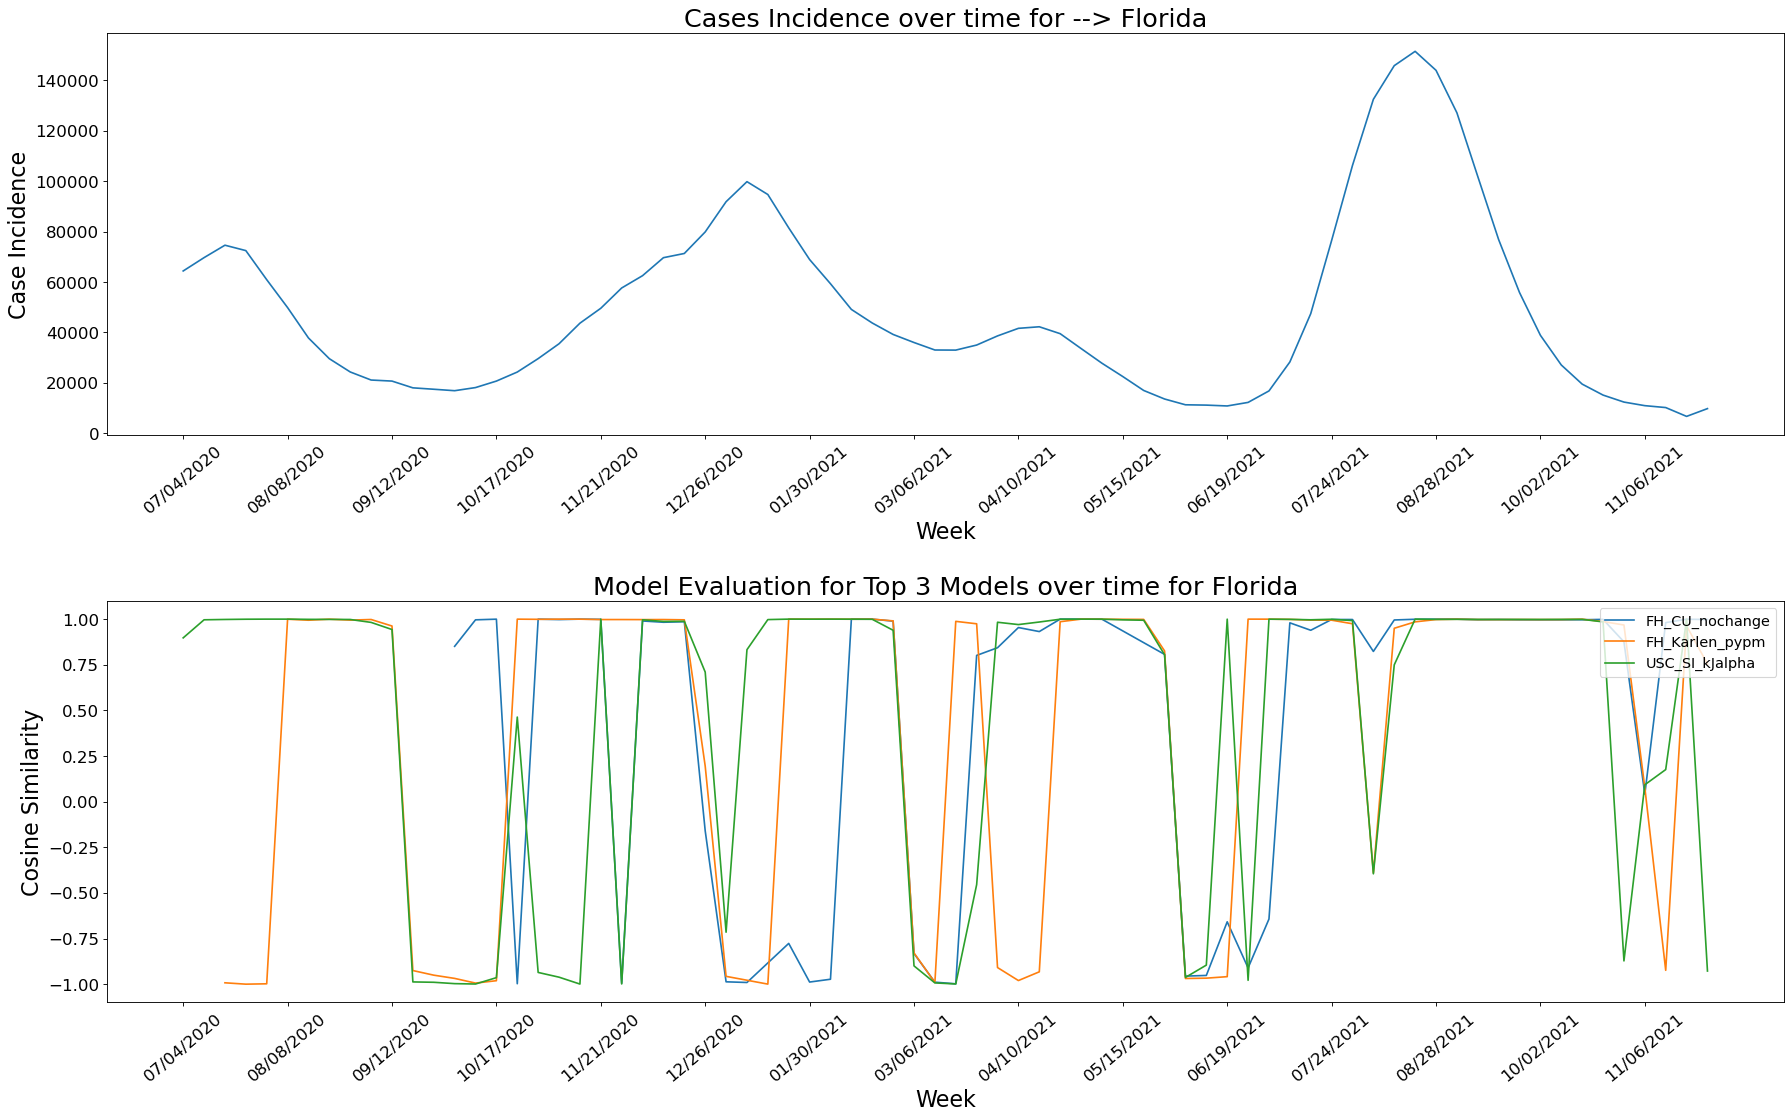

In [751]:
state_lst = State_list_plotting[:]

for state in state_lst:
    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    fig, axs = plt.subplots(2,figsize=(25,16 ), dpi=80)

    fig.tight_layout(pad=13.0)

    subset_data = plot_results_softmax[plot_results_softmax['State_x']==state].drop_duplicates(['Week Number','Label_Actual_x'])
    Actual_Case_cnt = (subset_data['Covid_case_count']/subset_data['Count_overall']).to_list()

    Predicted_label = subset_data['Predicted'].to_list()

    Actual_Label = subset_data['Label_Actual_x'].to_list()
    
    
    Week_nbr = subset_data['Week Number'].to_list()
    Week_nbr2 = Week_nbr[:]
    str_week_int = []
    str_week = []
    for i in range(0,len(Week_nbr),5):
        str_week_int.append(Week_nbr[i])
        str_week.append(date_formatting(Week_nbr[i]))

#         print(len(Week_nbr))

    axs[0].plot(Week_nbr,Actual_Case_cnt)
    axs[0].set_xlabel('Week', fontsize = 20)
    axs[0].set_ylabel('Case Incidence', fontsize = 20)
    
#     axs[0].set(xlabel="Week", ylabel="Covid Case Count")

    axs[0].set_title(Runtype+" Incidence over time for --> "+state,fontsize=23)
    axs[0].set_xticks(str_week_int)
    axs[0].set_xticklabels(str_week,rotation=40,fontsize=15)
    axs[0].yaxis.set_tick_params(labelsize=15)
    
    lgh = -999
    wek = None

    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    subset_1 = subset[subset['Model Name']==model_list[state][0]]
    
    x1 = subset_1['Week Number'].values
    
    y1 = subset_1['Cosine Similarty'].values
    
    if len(x1)>lgh:
        print("length of x1",len(x1))
        lgh = x1
        wek = x1
#     print
    vectors = list(zip(x1,y1))

    vector_sorted = sorted(vectors,key = lambda x : x[0]) 

    x = [w[0] for w in vector_sorted ]
    y = [w[1] for w in vector_sorted ]
    Week_nbr = x

    usc = axs[1].plot(x,y,label=model_list[state][0])


    axs[1].set_xlabel('Week', fontsize = 20)
    axs[1].set_ylabel('Cosine Similarity', fontsize = 20)
    
    
#     usc = axs[2].set(xlabel="Week", ylabel="Cosine Similarity",label = "USC Shapelet Ensemble")

    axs[1].set_title("Model Evaluation for Top 3 Models over time for {}".format(state),fontsize=23)
#         plt.show()

    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    subset_1 = subset[subset['Model Name']==model_list[state][1]]
    
    x11 = list(subset_1['Week Number'].values)
    print("length of x11",len(x11))
    y11 = subset_1['Cosine Similarty'].values
    if len(x11)>len(lgh):
        lgh = x11
        wek = x11

    
    vectors = list(zip(x11,y11))

    vector_sorted = sorted(vectors,key = lambda x : x[0]) 

    x = [w[0] for w in vector_sorted ]
    y = [w[1] for w in vector_sorted ]
    Week_nbr = x

    ensemble  = axs[1].plot(x,y,label=model_list[state][1])
    
    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    subset_1 = subset[subset['Model Name']==model_list[state][2]]
    
    x12 = list(subset_1['Week Number'].values)
    
    y12 = subset_1['Cosine Similarty'].values
    if len(x12)>len(lgh):
        lgh = x12
        wek = x12
    
    
    vectors = list(zip(x12,y12))

    vector_sorted = sorted(vectors,key = lambda x : x[0]) 

    x = [w[0] for w in vector_sorted ]
    y = [w[1] for w in vector_sorted ]
    Week_nbr = x

    ensemble2  = axs[1].plot(x,y,label=model_list[state][2])

#     axs[2].legend((usc,ensemble),('Perfis COPEX','Media'), loc = 'best')
    leg1 = axs[1].legend(loc='upper right',prop={'size': 13})
    
    str_week_int = []
    str_week = []
    for i in range(0,len(Week_nbr2),5):
        str_week_int.append(Week_nbr2[i])
        str_week.append(date_formatting(Week_nbr2[i]))
    axs[1].set_xticks(str_week_int)
    axs[1].set_xticklabels(str_week,rotation=40,fontsize=15)
    axs[1].yaxis.set_tick_params(labelsize=15)

    if export_visualizations:
        plt.savefig(Visualization_path+"PlotType : "+Runtype+" "+'Model_Evaluation Plot for Top3 Models '+state+'.png')
    else:
        plt.show()

In [752]:
subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
subset_1 = subset[subset['Model Name']==model_list[state][0]]


In [753]:

best_model_label_df = Master_df_actual_VS_Model_Agrrement.groupby(['True Label','Model Name']).agg(Mean_Score=("Cosine Similarty","mean")).reset_index()


In [754]:
best_model_label_df["rank"] = best_model_label_df.groupby(['True Label'])["Mean_Score"].rank("dense", ascending=False)


In [755]:
best_model_label_df.sort_values(['True Label','rank']).to_csv(Ouput_path+"Best_model_shapelet_6.csv")

In [756]:
Master_df_actual_VS_Model_Agrrement['True Label'].unique()

array(['Dec', 'Inc', 'Near Peak', 'Peaking', 'Surge', 'Flat'],
      dtype=object)

In [757]:

Master_df_actual_VS_Model_Agrrement['newlable'] = np.where(Master_df_actual_VS_Model_Agrrement['True Label'].isin(['Flat', 'Inc', 'Dec']),"Continued Trend","Others")


In [758]:
Master_df_actual_VS_Model_Agrrement


best_model_label_df = Master_df_actual_VS_Model_Agrrement.groupby(['newlable','Model Name']).agg(Mean_Score=("Cosine Similarty","mean")).reset_index()

best_model_label_df["rank"] = best_model_label_df.groupby(['newlable'])["Mean_Score"].rank("dense", ascending=False)


In [759]:

best_model_label_df.sort_values(['newlable','rank']).to_csv(Ouput_path+"Best_model_shapelet_continued_trendVS_others.csv")



## End of Notebook

Author Details :

Satwant Singh : satwants@usc.edu



## Appendix 

Below codes are useful in generating some interesting visualizations



### 1) Aggrement between models over time for given state. Also Covid-19 Case/death incidence data is plotted to visualize better



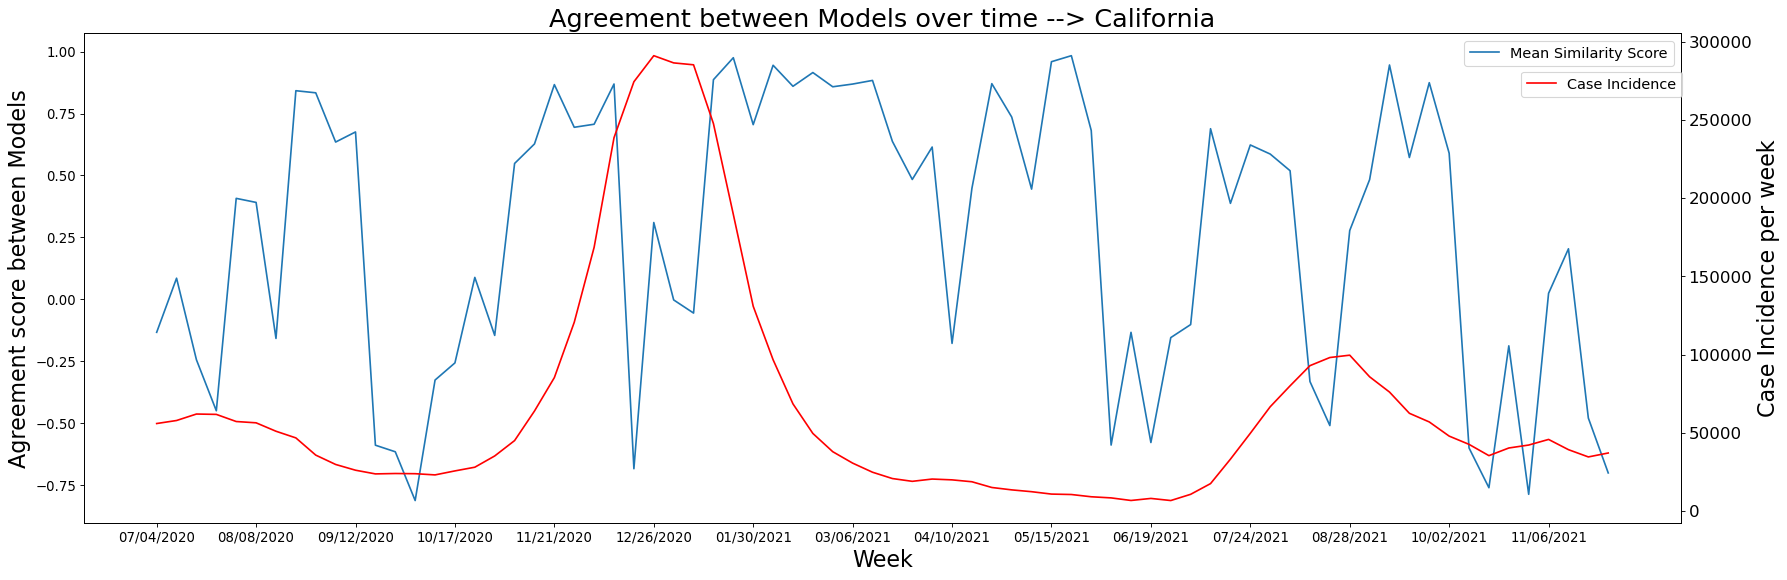

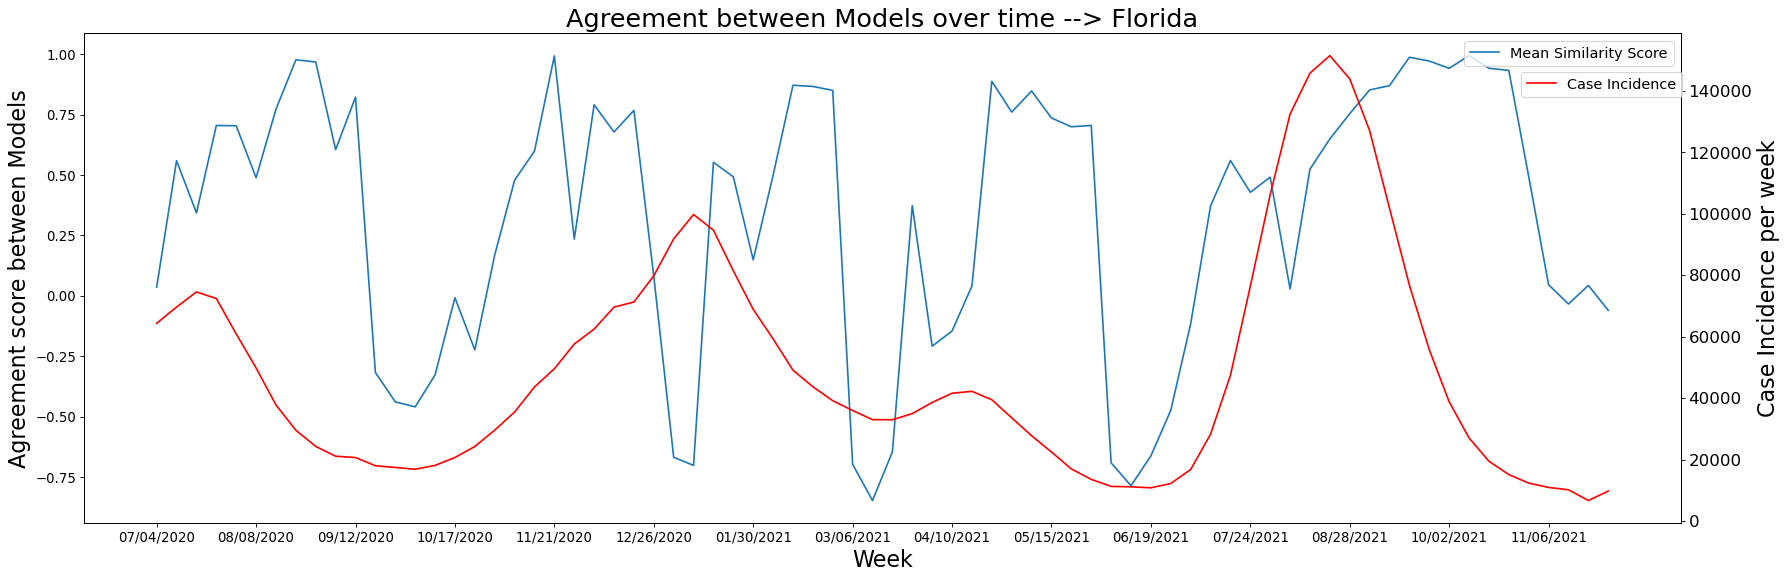

In [760]:
state_lst = State_list_plotting[:]

for state in state_lst:
    model = "USC shapelet-ensemble"
#     if state not in ['California','United States']:
#         continue
    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    fig, axs = plt.subplots(1,figsize=(24,10 ), dpi=80)

    fig.tight_layout(pad=13.0)

    subset_data = plot_results_softmax[plot_results_softmax['State_x']==state].drop_duplicates(['Week Number','Label_Actual_x'])
    Actual_Case_cnt = (subset_data['Covid_case_count']/subset_data['Count_overall']).to_list()

    Predicted_label = subset_data['Predicted'].to_list()

    Actual_Label = subset_data['Label_Actual_x'].to_list()

    Week_nbr = subset_data['Week Number'].to_list()
    str_week_int = []
    str_week = []
    for i in range(0,len(Week_nbr),5):
        str_week_int.append(Week_nbr[i])
        str_week.append(date_formatting(Week_nbr[i]))

#         print(len(Week_nbr))
    a2 = axs.twinx()
    q = a2.plot(Week_nbr,Actual_Case_cnt,label="Case Incidence",color="red")
#     a2.set_xlabel('Week', fontsize = 20)
    a2.set_ylabel('Case Incidence per week', fontsize = 20)
    
#     axs[0].set(xlabel="Week", ylabel="Covid Case Count")

#     axs[0].set_title(Runtype+" Incidence over time for --> "+state,fontsize=23)
    a2.set_xticks(str_week_int)
    a2.set_xticklabels(str_week,rotation=40,fontsize=15)
    a2.yaxis.set_tick_params(labelsize=15)
#     axs[0].set_yticklabels(fontsize=13)
#     axs[0].set_yticks(Actual_Case_cnt)
#     axs[0].set_yticklabels(Actual_Case_cnt,fontsize=13)
    
    
    subset = MeanSimilarityModels[MeanSimilarityModels['State']==state]

    week_nbrs = list(subset['Week Number'].values)

    meanS_miliary = subset['Mean_Similarity'].values
    
    b = axs.plot(week_nbrs,meanS_miliary,label="Mean Similarity Score")
    axs.set_xlabel('Week', fontsize = 20)
    axs.set_ylabel('Agreement score between Models', fontsize = 20)
    axs.yaxis.set_tick_params(labelsize='large')
    axs.xaxis.set_tick_params(labelsize='large')
#     axs.xtick.labelsize(20)
#     axs.xaxis.set_size(20)
#     axs.set_yticklabels(fontsize=13)

#     axs[1].set(xlabel="Week Number", ylabel="Agreement score between Models")

    axs.set_title("Agreement between Models over time --> "+state,fontsize=23)
    
    leg1 = axs.legend(loc='upper right',prop={'size': 13})
    leg1 = a2.legend(loc=(0.90, 0.87),prop={'size': 13})
    if export_visualizations:
    
        plt.savefig(Visualization_path+"Agrrement_score_Paper_"+state+".png")
    else:
        plt.show()


### 2) Shapelet Label Annotation plotted with Covid-19 Case/Death incidence data plotted to verify annotation method quality

In [761]:
from random import sample


In [762]:
import math

In [763]:
# scenes_dict= {}
# for index,val in enumerate(list(set([w[2] for w in scenarios_list_pearson_perason_1]))):
#     scenes_dict[val] = val[0]
    

In [764]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np


In [765]:
Number_of_shapelets

6

California


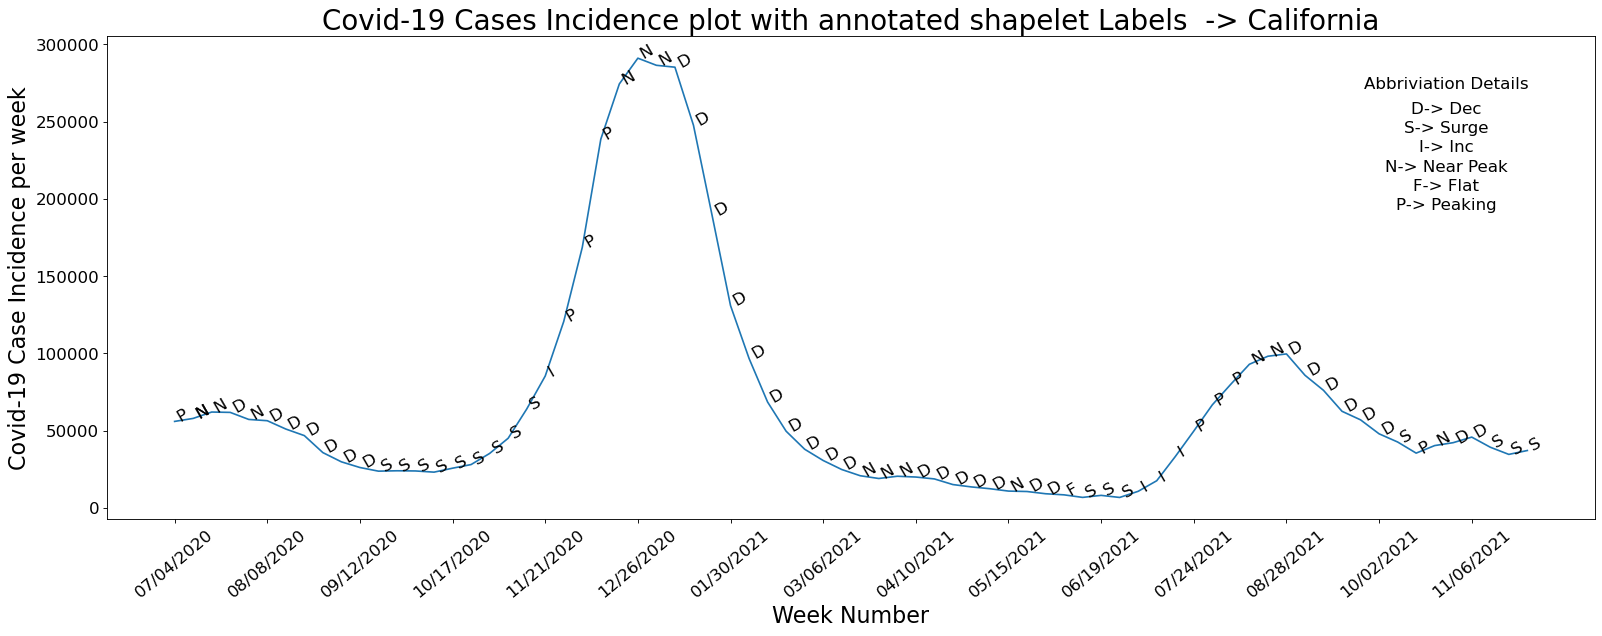

Florida


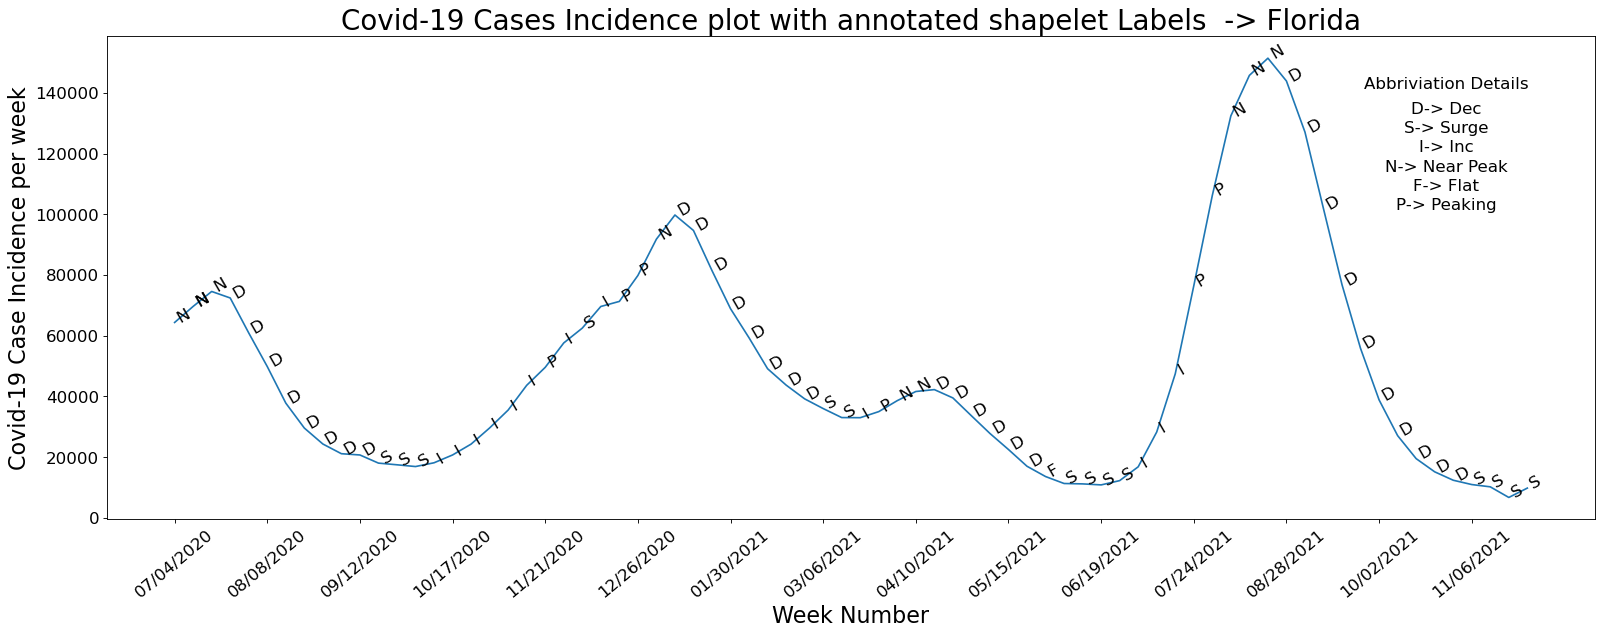

In [766]:
ShapeLet_Dictionary_State_level = {}

Shapelet_dict_actual_state_week_vector_label = {}

for keys in running_average.keys():
    
    State_name = keys
    if keys in Ignore_State_list:
        continue
    print(keys)
    running_avg = running_average[State_name]



    running_avg_vectors = []
    for i in range(len(running_avg)):
        if i<len(running_avg)-4:
            if i<=history_weeks:
                vec = running_avg[i:i+future_weeks+history_weeks]
            else:
                vec = running_avg[i-history_weeks:i+future_weeks]
#             vec = running_avg[i-history_weeks:i+future_weeks]
            vec1 = [w[1] for w in vec]

            week_nbr = vec[0][0]
            running_avg_vectors.append((week_nbr,vec1[0],vec1))

    dicy_state = Shapelet_dict_actual_state_week_vector_label.get(State_name,{})
#     print(dicy_state)
    
    scenarios_list_pearson_perason = [(vector[0],vector[1],return_best_shapelet_pearson(vector[2]),return_all_shapelet_pearson(vector[2])) for vector in running_avg_vectors]
    scenes_dict= {}
    for index,val in enumerate(list(set([w[2] for w in scenarios_list_pearson_perason]))):
        scenes_dict[val] = val[0]
    
    for vector in scenarios_list_pearson_perason:
        dicy_state[vector[0]] = [(vector[3],vector[2])]
    Shapelet_dict_actual_state_week_vector_label[State_name] = dicy_state
        

    ShapeLet_Dictionary_State_level[keys] = scenarios_list_pearson_perason

    ## Actual Covid tally plot validation 

    week_nbr_plt = [w[0] for w in scenarios_list_pearson_perason]
    actual_count_plt = [w[1] for w in scenarios_list_pearson_perason]
    labels_plt = [w[2] for w in scenarios_list_pearson_perason]


#     fig, ax = plt.subplots()
    fig, axs = plt.subplots(1,figsize=(24,8 ), dpi=80)
#     figure(figsize=(24,8 ), dpi=80)
    Week_nbr2 = week_nbr_plt
    str_week_int = []
    str_week = []
    for i in range(0,len(Week_nbr),5):
        str_week_int.append(Week_nbr[i])
        str_week.append(date_formatting(Week_nbr[i]))

    axs.plot(week_nbr_plt,actual_count_plt)
    axs.set_xticks(str_week_int)
    axs.set_xticklabels(str_week,rotation=40,fontsize=15)
    axs.yaxis.set_tick_params(labelsize=15)
#     plt.se
    axs.set_xlabel('Week Number', fontsize = 20)
    axs.set_ylabel('Covid-19 Case Incidence per week', fontsize = 20)

#     axs.setxlabel("Week Number")
#     axs[0].ylabel("Covid-19 Case Volume")
    axs.set_title("Covid-19 "+Runtype+" Incidence plot with annotated shapelet Labels  -> {}".format(State_name),fontsize=25)
    
#     scenarios_list_pearson_perason_1 = sample(scenarios_list_pearson_perason,math.ceil(len(scenarios_list_pearson_perason)*0.95))
    for index,val in enumerate(scenarios_list_pearson_perason):
#         if index%2==0:
#             continue
        axs.text(val[0],val[1],scenes_dict[val[2]],fontsize=15,rotation=30)
    axs.text(0.9, 0.9,'Abbriviation Details',\
    horizontalalignment='center',\
    verticalalignment='center', transform = axs.transAxes,fontsize=15) 
    step=-0.1
    cnt=0
    for k11,v11 in scenes_dict.items():
        axs.text(0.9, 0.85+cnt*step,v11+ "-> "+k11,\
        horizontalalignment='center',\
        verticalalignment='center',transform = axs.transAxes,fontsize=15)  
        cnt+=0.4
    if export_visualizations:
        plt.savefig(Visualization_path+'Type : '+Runtype+'Shapelets_actual_cases_'+State_name+'.png')
    else:
        plt.show()

In [767]:
# endtime = time.time()

# print("Time Taken by Notebook {}".format(((endtime-start)/60)))